In [11]:
from skimage.measure import label, regionprops

import numpy as np

import glob
import sys
import xarray as xr
import numpy as np
import cartopy
import scipy
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter
import pandas as pd
import glob
from IPython.core.debugger import set_trace
from shapely.geometry import Polygon
import geopandas as gpd
import geopy.distance
import shapely
from cartopy.geodesic import Geodesic
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd

from math import sin, cos, sqrt, atan2, radians

import warnings
warnings.filterwarnings('ignore')
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(crs=crs)
import cProfile

In [12]:
def process_ot_data(file, thresh=.7):
    
    # Set the coordinate reference system
    crs = {'init': 'epsg:4326'}
    ot_data = gpd.GeoDataFrame()
    
    ds_og = xr.open_dataset(file).squeeze()
    
    time = ds_og.time.values
    
    inx = np.where((ds_og['longitude'] >= llcrnr[1]) & (ds_og['longitude'] <= urcrnr[1]))[0]
    iny = np.where((ds_og['latitude'] >= llcrnr[0]) & (ds_og['latitude'] <= urcrnr[0]))[0]

    ds = ds_og.sel(npixels=inx, nlines=iny)
    
    lat = ds['latitude'].values
    lon = ds['longitude'].values
    
    #time = bedka['time'].isel(time=t).values    
    lon_2d, lat_2d = np.meshgrid(lon,lat)
    
    lon_2d_corrected = lon_2d + ds['parallax_correction_longitude'].fillna(0).values
    lat_2d_corrected = lat_2d + ds['parallax_correction_latitude'].fillna(0).values
    
    #inx = np.where((ds['longitude'] >= llcrnr[1]) & (ds['longitude'] <= urcrnr[1]))[0]
    #iny = np.where((ds['latitude'] >= llcrnr[0]) & (ds['latitude'] <= urcrnr[0]))[0]

    time_label = pd.to_datetime(ds.time.values).strftime('%Y-%m-%d %H:%M')
    
    ds_whole = ds

    ds = ds_og.sel(npixels=inx, nlines=iny)
    db = ds.ot_probability
    dc = ds.ot_id_number
    da = ds.ir_brightness_temperature
    dc = ds.ot_id_number
    de = ds.ot_anvilmean_brightness_temperature_difference
    cloud_hgt = ds.cloud_top_height
    trop_hgt = ds.tropopause_height
    trop_tmp = ds.tropopause_temperature
    trop_pres = ds.tropopause_pressure

    smoothed_tb = gaussian_filter(da.values, 1)

    plot_num=0
    
    ot_ids = ds_og.where(ds_og.ot_probability > thresh).ot_id_number.values
    good_ots = np.unique(ot_ids[np.where(ot_ids > 0)])

    for i in good_ots[0:5]:
    
        minpt = np.where(dc == i)
        print(minpt)
        
    
        dbs = db.values[minpt]
        ddlat = lat_2d[minpt]
        ddlon = lon_2d[minpt]
        ddlat_corr = lat_2d_corrected[minpt]
        ddlon_corr = lon_2d_corrected[minpt]
        das = da.values[minpt]
        dde = de.values[minpt]
        
        try:
            mintb = np.nanmin(das)
            
        except:
            continue
            
        dbs = db.values[minpt]
        minloc = np.argmin(das)
        prob = dbs[minloc]
        ddc = dc.values[minpt]
        otid = ddc[minloc]
        lat = ddlat[minloc]
        lon = ddlon[minloc]
        lon_corrected = ddlon_corr[minloc]
        lat_corrected = ddlat_corr[minloc]
        thgt = trop_hgt.values[minpt][minloc]
        ttmp = trop_tmp.values[minpt][minloc]
        tprs = trop_pres.values[minpt][minloc]
        clhgt = cloud_hgt.values[minpt][minloc]
    
        if prob > thresh:
    
            try:
            #print(minpt)
                y0, x0 = np.where(ds.ir_brightness_temperature.values == ds.ir_brightness_temperature.values[minpt].min())
                x0 = int(x0[0])
                y0 = int(y0[0])
                
                lat, lon = ds.sel(nlines=y0, npixels=x0).latitude.values, ds.sel(nlines=y0, npixels=x0).longitude.values


            except Exception as e: 
                print(e)
        
            num = 20
            hyp = 20 * np.cos(45, dtype='d')
            x1_all = [x0      , x0 + hyp, x0 + num, x0 + hyp, x0      , x0 - hyp, x0 - num, x0 - hyp]
            y1_all = [y0 + num, y0 + hyp, y0      , y0 - hyp, y0 - num, y0 - hyp, y0      , y0 + hyp]
        
            pts=np.zeros([8,41])
            lats = np.zeros([8,41])
            lons = np.zeros([8,41])
            x_rads = np.zeros([8,41])
            y_rads = np.zeros([8,41])
                            
            j=0
            
            for x1, y1 in zip(x1_all,y1_all):

                x, y = np.linspace(x0, x1, (num * 2) + 1), np.linspace(y0, y1, (num * 2) + 1)
                pts[j,:] = scipy.ndimage.map_coordinates(smoothed_tb, np.vstack((y,x)))
                lats[j,:] = scipy.ndimage.map_coordinates(lat_2d, np.vstack((y,x)))
                lons[j,:] = scipy.ndimage.map_coordinates(lon_2d, np.vstack((y,x)))
                j = j + 1
            
            dels = np.gradient(np.gradient(pts.T,axis=0),axis=0)
            
            tb_rads = pts
            
            # Find inflection points
            dels_zero = np.argmax(dels <= 0, axis=0)
            
            # Calculate mean and standard deviation of radials
            mean = np.mean(dels_zero)
            std = np.std(dels_zero)
            
            # Replace radials with mean radial if greater than 1 standard deviation from mean
            dels_zero = np.where(dels_zero > (mean + std), int(np.round(mean)), dels_zero)
            
            ind = np.arange(0,8)
            
            lat_mins = lats[ind, dels_zero]
            lon_mins = lons[ind, dels_zero]
            
            # Calcualte the distance for each radial
            
            dists = []
            for i in range(len(dels_zero)):
                dists.append(geopy.distance.distance((lat, lon), (lat_mins[i], lon_mins[i])).kilometers)
            dists = np.array(dists)
                            
            # setup a polygon
            crs = {'init': 'epsg:4326'}
            polygon_geom = Polygon(zip(lon_mins, lat_mins))
        
            gdf = gpd.GeoDataFrame(crs=crs)
            gdf = gdf.append({'otid':i,
                              'geometry':polygon_geom}, ignore_index=True)
        
            gdf['otarea_from_polygon'] = gdf['geometry'].to_crs({'init': 'epsg:32719'})\
                                         .map(lambda p: p.area / 10**6)
            
            
            otarea_from_polygon = gdf.otarea_from_polygon.values[0]
            
            print(list(tuple(dels[:, 0])))
            try:
                
                ot_data = ot_data.append({'time':time,
                                          'lat':lat,
                                          'lon':lon,
                                          'lat_corr':lat_corrected,
                                          'lon_corr':lon_corrected,
                                          'otid':otid,
                                          'mintb':mintb,
                                          'tropopause_height':thgt,
                                          'tropopause_temperature':ttmp,
                                          'tropopause_pressure':tprs,
                                          'cloudtop_height':clhgt,
                                          'prob':prob,
                                          'area_polygon':otarea_from_polygon,
                                          's_radial':dists[0],
                                          's_radial_del2':dels[:, 0],
                                          's_tb':tb_rads[0],
                                          'se_radial':dists[1],
                                          'se_radial_del2':dels[:, 1],
                                          'se_tb':tb_rads[1],
                                          'e_radial':dists[2],
                                          'e_radial_del2':dels[:, 2],
                                          'e_tb':tb_rads[2],
                                          'ne_radial':dists[3],
                                          'ne_radial_del2':dels[:, 3],
                                          'ne_tb':tb_rads[3],
                                          'n_radial':dists[4],
                                          'n_radial_del2':dels[:, 4],
                                          'n_tb':tb_rads[4],
                                          'nw_radial':dists[5],
                                          'nw_radial_del2':dels[:, 5],
                                          'nw_tb':tb_rads[5],
                                          'w_radial':dists[6],
                                          'w_radial_del2':dels[:, 6],
                                          'w_tb':tb_rads[6],
                                          'sw_radial':dists[7],
                                          'sw_radial_del2':dels[:, 7],
                                          'sw_tb':tb_rads[7],
                                          'geometry':polygon_geom}, ignore_index=True)
                
                
            
            except Exception as e:
                print(e)
    try:
        ot_data = ot_data[ot_data.area_polygon < 1000]
        filename = pd.to_datetime(time).strftime('ot_output/%Y%m%d/%Y%m%d_%H%M.csv')
    
        ot_data.to_csv(filename)
        
    except:
        None
    
    ds_og.close()
    ds.close()
    
    return ot_data

In [4]:
from dask.distributed import Client
from dask.distributed import progress
client = Client(n_workers=10)

In [13]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

import glob
datestr='20181110'
ihour='20'
files = sorted(glob.glob(f'/data/relamp/a/mgrover4/ot_data/{datestr}/*{ihour}????.cdf'))

In [21]:
futures = client.map(process_ot_data, files)

In [22]:
progress(futures)

VBox()

In [15]:
files[7]

'/data/relamp/a/mgrover4/ot_data/20181110/cor1goecnvX1.a1.20181110.200755.cdf'

<AxesSubplot:>

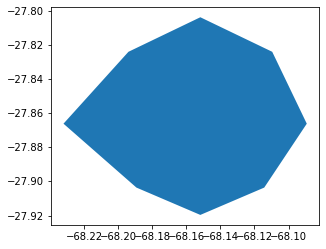

In [11]:
df_ex.plot()

In [14]:
df

area_polygon cloudtop_height              e_radial  \
0  [189.27241165070697]     [17.449001]   [4.212812185367112]   
1  [12.550535250836726]         [16.94]  [1.1013114809103366]   

                                       e_radial_del2  \
0  [[0.290618896484375, 0.4165229797363281, 0.477...   
1  [[0.16606903076171875, -49.933895111083984, -4...   

                                                e_tb  \
0  [[198.69674682617188, 199.47158813476562, 200....   
1  [[201.2448272705078, 200.7417449951172, 200.57...   

                                            geometry           lat  \
0  POLYGON ((-64.16964 -32.17857, -64.13212 -32.1...  [-32.116074]   
1  POLYGON ((-62.65179 -32.87500, -62.63950 -32.8...  [-32.848213]   

       lat_corr          lon     lon_corr  ...            sw_radial  \
0  [-31.994074]  [-64.16964]  [-64.21364]  ...   [11.6087078557941]   
1  [-32.725212]  [-62.65179]  [-62.70079]  ...  [2.062344902400382]   

                                      sw_radial_del2  \
0  [[0.1139068603515625, 0.16944503784179688, 0.2...   
1  [[0.03946685791015625, 0.048191070556640625, 0...   

                                               sw_tb  \
0  [[198.69674682617188, 198.6677703857422, 198.8...   
1  [[201.2448272705078, 201.73597717285156, 202.3...   

                              time tropopause_height tropopause_pressure  \
0  [2018-11-10T20:01:55.000000512]          [16.613]             [97.78]   
1  [2018-11-10T20:01:55.000000512]       [16.303001]            [103.07]   

  tropopause_temperature              w_radial  \
0               [202.53]  [10.111900925920189]   
1               [203.36]  [2.4875926588057156]   

                                       w_radial_del2  \
0  [[0.28107452392578125, 0.4053764343261719, 0.5...   
1  [[0.09966278076171875, 0.11639022827148438, 0....   

                                                w_tb  
0  [[198.69674682617188, 198.53431701660156, 198....  
1  [[201.2448272705078, 202.0481719970703, 203.05...  

[2 rows x 38 columns]

(array([], dtype=int64), array([], dtype=int64))
(array([100, 100, 100, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102,
       102, 103, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104, 104,
       105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 107, 107]), array([96, 97, 98, 95, 96, 97, 98, 99, 94, 95, 96, 97, 98, 99, 94, 95, 96,
       97, 98, 99, 94, 95, 96, 97, 98, 99, 94, 95, 96, 97, 98, 99, 94, 95,
       96, 97, 98, 96, 97]))
[0.12656402587890625, 0.21025848388671875, 0.3373603820800781, 0.416046142578125, 0.4304847717285156, 0.3276824951171875, 0.13058090209960938, -0.10853195190429688, -0.29584503173828125, -0.3458709716796875, -0.24800872802734375, -0.01619720458984375, 0.3123283386230469, 0.6859512329101562, 1.0188484191894531, 1.2207565307617188, 1.2178878784179688, 0.9721183776855469, 0.5715103149414062, 0.13589096069335938, -0.21406936645507812, -0.3926353454589844, -0.4545631408691406, -0.4859619140625, -0.5580825805664062, -0.7099609375, -0.8664016723632812, -

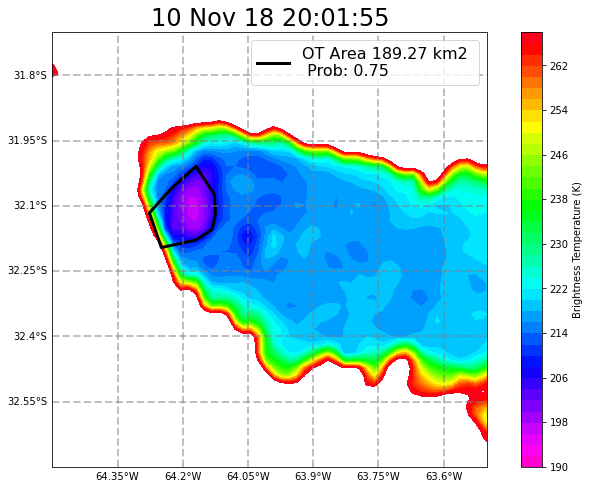

(array([], dtype=int64), array([], dtype=int64))
(array([ 99,  99, 100, 100, 100, 100, 101, 101, 101, 101, 101, 102, 102,
       102, 102, 102, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104,
       105, 105, 105, 105, 105, 106, 106, 106, 106, 106, 107, 107, 107]), array([97, 98, 96, 97, 98, 99, 95, 96, 97, 98, 99, 95, 96, 97, 98, 99, 95,
       96, 97, 98, 99, 95, 96, 97, 98, 99, 95, 96, 97, 98, 99, 95, 96, 97,
       98, 99, 96, 97, 98]))
[0.06288909912109375, 0.094879150390625, 0.14159774780273438, 0.1853485107421875, 0.2329864501953125, 0.25424957275390625, 0.24602890014648438, 0.21316909790039062, 0.16518783569335938, 0.11025619506835938, 0.046466827392578125, -0.02402496337890625, -0.07268905639648438, -0.06418228149414062, 0.037685394287109375, 0.2624053955078125, 0.6118431091308594, 1.0559425354003906, 1.4646034240722656, 1.6844215393066406, 1.5687828063964844, 1.0328445434570312, 0.23203277587890625, -0.6170082092285156, -1.2929763793945312, -1.621978759765625, -1.6246109008

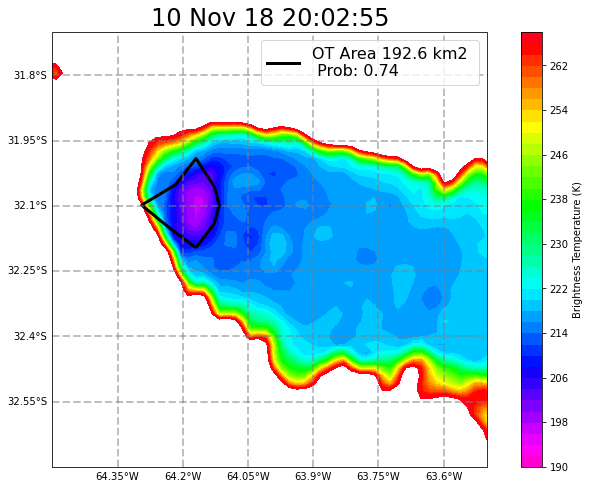

(array([ 99,  99, 100, 100, 100, 100, 101, 101, 101, 101, 101, 102, 102,
       102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 104, 104, 104,
       104, 104, 105, 105, 105, 105, 105, 106, 106, 106, 107]), array([ 98,  99,  96,  97,  98,  99,  95,  96,  97,  98,  99,  95,  96,
        97,  98,  99, 100,  95,  96,  97,  98,  99, 100,  95,  96,  97,
        98,  99,  95,  96,  97,  98,  99,  96,  97,  98,  97]))
[0.12308502197265625, 0.17851638793945312, 0.22521209716796875, 0.20931243896484375, 0.18198776245117188, 0.12690353393554688, 0.049770355224609375, -0.034698486328125, -0.09782791137695312, -0.1138916015625, -0.08288955688476562, -0.016384124755859375, 0.053558349609375, 0.09736251831054688, 0.11587905883789062, 0.13052749633789062, 0.21452713012695312, 0.4394035339355469, 0.8181724548339844, 1.3132514953613281, 1.7432174682617188, 1.9023933410644531, 1.6318855285644531, 0.8623695373535156, -0.16397476196289062, -1.1387138366699219, -1.7999038696289062, -1.9700546264648438, -

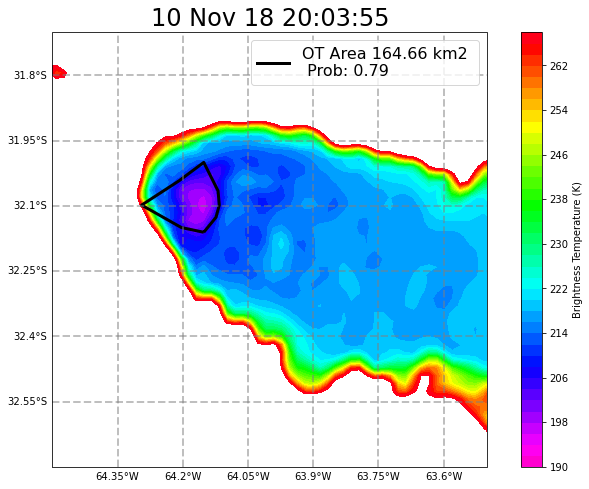

(array([100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 102, 102, 102,
       102, 102, 102, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104,
       105, 105, 105, 105, 106, 106, 106]), array([ 96,  97,  98,  99, 100,  96,  97,  98,  99, 100,  95,  96,  97,
        98,  99, 100,  96,  97,  98,  99, 100,  96,  97,  98,  99, 100,
        96,  97,  98,  99,  96,  97,  98]))
[0.195098876953125, 0.292388916015625, 0.37154388427734375, 0.31085968017578125, 0.20941925048828125, 0.07967758178710938, -0.06451416015625, -0.20551681518554688, -0.3120079040527344, -0.3532295227050781, -0.31429290771484375, -0.19583511352539062, -0.044681549072265625, 0.08864974975585938, 0.18495941162109375, 0.23891067504882812, 0.26934814453125, 0.3047904968261719, 0.38824462890625, 0.5643157958984375, 0.8695297241210938, 1.2995643615722656, 1.6948661804199219, 1.8624725341796875, 1.6309471130371094, 0.9045982360839844, -0.1308135986328125, -1.2031669616699219, -1.9764328002929688, -2.1878814697265625, -1.9317

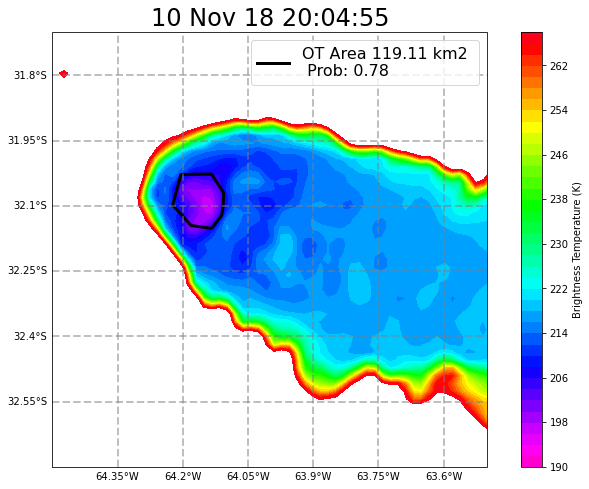

(array([ 99, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 101, 102,
       102, 102, 102, 102, 103, 103, 103, 103, 103, 104, 104, 104, 104,
       104, 105, 105, 105, 105, 105, 106, 106]), array([ 97,  96,  97,  98,  99, 100,  95,  96,  97,  98,  99, 100,  96,
        97,  98,  99, 100,  96,  97,  98,  99, 100,  96,  97,  98,  99,
       100,  96,  97,  98,  99, 100,  98,  99]))
[0.133056640625, 0.17291641235351562, 0.17094802856445312, 0.11048126220703125, 0.12012481689453125, 0.21378326416015625, 0.31855010986328125, 0.3505973815917969, 0.2692413330078125, 0.06762313842773438, -0.16886138916015625, -0.3426361083984375, -0.399749755859375, -0.3185844421386719, -0.16322708129882812, -0.00748443603515625, 0.12172317504882812, 0.21417236328125, 0.2794647216796875, 0.330963134765625, 0.3773002624511719, 0.4345283508300781, 0.5530929565429688, 0.7720222473144531, 1.0502281188964844, 1.3098983764648438, 1.4064521789550781, 1.211151123046875, 0.725433349609375, 0.0106658935546875, -0.76

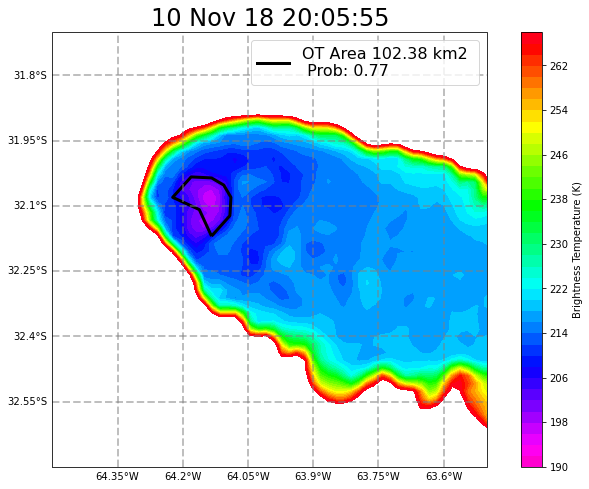

(array([ 99, 100, 100, 100, 100, 100, 101, 101, 101, 101, 101, 102, 102,
       102, 102, 102, 103, 103, 103, 103, 103, 103, 104, 104, 104, 104,
       104, 104, 105, 105, 105, 105, 106, 106, 106, 106]), array([ 99,  97,  98,  99, 100, 101,  97,  98,  99, 100, 101,  97,  98,
        99, 100, 101,  96,  97,  98,  99, 100, 101,  96,  97,  98,  99,
       100, 101,  97,  98,  99, 100,  97,  98,  99, 100]))
[0.10990142822265625, 0.15162277221679688, 0.18276596069335938, 0.18071365356445312, 0.1980743408203125, 0.20357894897460938, 0.15364456176757812, 0.02036285400390625, -0.14923477172851562, -0.2913551330566406, -0.3500175476074219, -0.2927055358886719, -0.17296600341796875, -0.055355072021484375, 0.037631988525390625, 0.10175704956054688, 0.16379547119140625, 0.24543380737304688, 0.31694793701171875, 0.3441734313964844, 0.32654571533203125, 0.2953453063964844, 0.3756561279296875, 0.6715507507324219, 1.1091957092285156, 1.5433540344238281, 1.7211990356445312, 1.4326324462890625, 0.745979

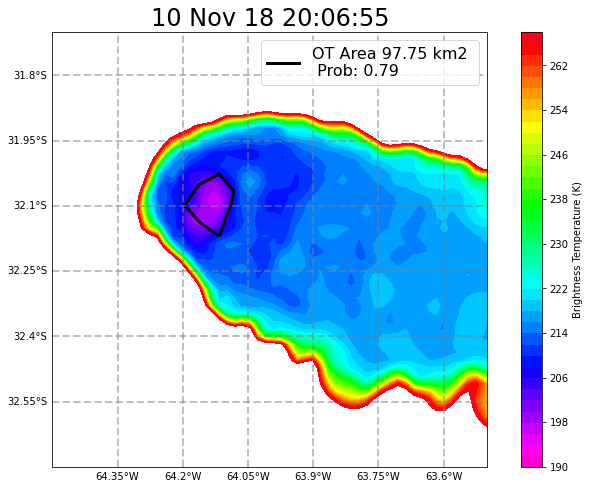

(array([ 99,  99,  99, 100, 100, 100, 100, 101, 101, 101, 101, 102, 102,
       102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 104, 104, 104,
       104, 104, 104, 104, 105, 105, 105, 105, 105, 106, 106, 106, 106]), array([ 99, 100, 101,  98,  99, 100, 101,  98,  99, 100, 101,  98,  99,
       100, 101, 102,  96,  97,  98,  99, 100, 101, 102,  96,  97,  98,
        99, 100, 101, 102,  97,  98,  99, 100, 101,  97,  98,  99, 100]))
[0.14574432373046875, 0.22163009643554688, 0.3123970031738281, 0.3466339111328125, 0.3545799255371094, 0.29303741455078125, 0.15742874145507812, -0.0376129150390625, -0.23914718627929688, -0.3901786804199219, -0.4558906555175781, -0.41561126708984375, -0.2830047607421875, -0.08865737915039062, 0.10348892211914062, 0.2390899658203125, 0.3354988098144531, 0.424774169921875, 0.5261001586914062, 0.6346092224121094, 0.6621131896972656, 0.5411872863769531, 0.37079620361328125, 0.2830619812011719, 0.37641143798828125, 0.6833686828613281, 1.0064010620117188, 1.1128

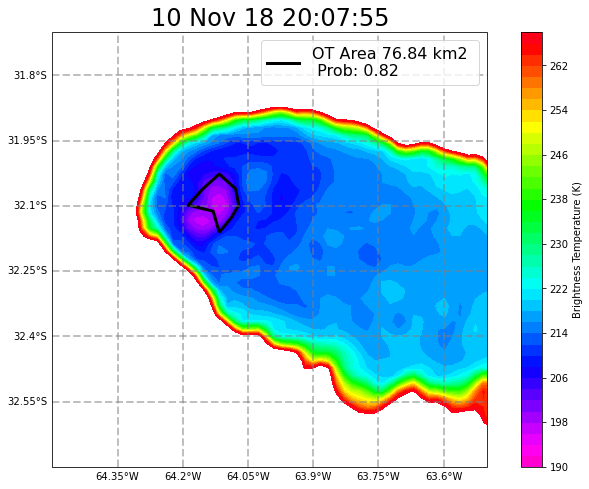

(array([ 99,  99, 100, 100, 100, 100, 101, 101, 101, 101, 102, 102, 102,
       102, 102, 103, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104,
       104, 105, 105, 105, 105, 105, 106, 106, 106, 106]), array([100, 101,  99, 100, 101, 102,  99, 100, 101, 102,  98,  99, 100,
       101, 102,  97,  98,  99, 100, 101, 102,  97,  98,  99, 100, 101,
       102,  98,  99, 100, 101, 102,  98,  99, 100, 101]))
[0.16942596435546875, 0.2620735168457031, 0.3797264099121094, 0.43326568603515625, 0.4531745910644531, 0.3882637023925781, 0.22670364379882812, -0.02011871337890625, -0.2873382568359375, -0.5016059875488281, -0.6090316772460938, -0.57464599609375, -0.4197654724121094, -0.18807220458984375, 0.04360198974609375, 0.20503997802734375, 0.2855796813964844, 0.3016624450683594, 0.31859588623046875, 0.39563751220703125, 0.5190010070800781, 0.6478233337402344, 0.7060050964355469, 0.6369705200195312, 0.4974517822265625, 0.3764152526855469, 0.3784980773925781, 0.5634651184082031, 0.7959175109863281

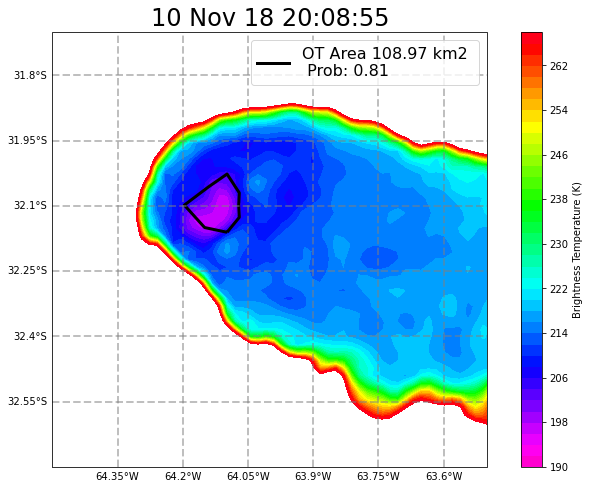

(array([101, 101, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103,
       103, 104, 104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105,
       105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 107, 107, 107,
       107]), array([ 99, 100,  98,  99, 100, 101, 102,  96,  97,  98,  99, 100, 101,
       102,  96,  97,  98,  99, 100, 101, 102, 103,  96,  97,  98,  99,
       100, 101, 102,  96,  97,  98,  99, 100, 101, 102,  97,  98,  99,
       100]))
[0.2967987060546875, 0.4472198486328125, 0.5501899719238281, 0.3894805908203125, 0.14293670654296875, -0.11710739135742188, -0.3037376403808594, -0.34767913818359375, -0.26467132568359375, -0.0821685791015625, 0.21044158935546875, 0.6166954040527344, 1.0737762451171875, 1.4862098693847656, 1.6943244934082031, 1.5653495788574219, 1.1382827758789062, 0.5120391845703125, -0.14661407470703125, -0.6822052001953125, -1.0524024963378906, -1.2525863647460938, -1.3156890869140625, -1.2751312255859375, -1.128631591796875, -0.8805313110351562, 

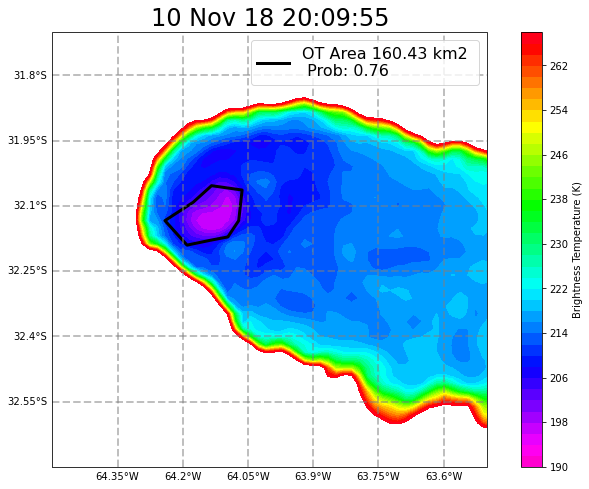

(array([101, 101, 102, 102, 102, 102, 102, 103, 103, 103, 103, 103, 103,
       103, 104, 104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105,
       105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 107, 107,
       107, 107]), array([ 99, 100,  98,  99, 100, 101, 102,  96,  97,  98,  99, 100, 101,
       102,  96,  97,  98,  99, 100, 101, 102, 103,  96,  97,  98,  99,
       100, 101, 102, 103,  96,  97,  98,  99, 100, 101, 102,  97,  98,
        99, 100]))
[0.24774932861328125, 0.36989593505859375, 0.4546051025390625, 0.33487701416015625, 0.14990234375, -0.058277130126953125, -0.22616958618164062, -0.2980842590332031, -0.2710304260253906, -0.15498733520507812, 0.040897369384765625, 0.32234954833984375, 0.7537307739257812, 1.3645439147949219, 1.986297607421875, 2.3822860717773438, 2.240875244140625, 1.3637466430664062, 0.08073043823242188, -1.1657028198242188, -2.0106544494628906, -2.2133636474609375, -1.9520187377929688, -1.4893417358398438, -1.0072555541992188, -0.6364517211

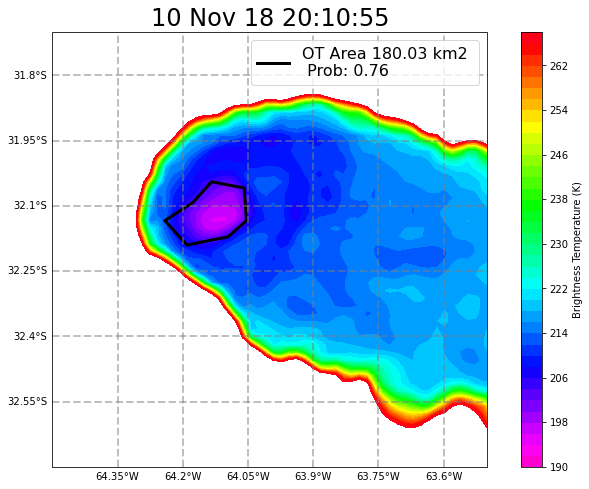

(array([100, 100, 100, 101, 101, 101, 102, 102, 103, 103, 103, 104, 104,
       105, 105, 106, 107, 107]), array([ 99, 100, 101,  98,  99, 100,  97,  98,  96,  97,  98,  96,  97,
        96,  97,  97,  97,  98]))
[0.15045166015625, 0.2281494140625, 0.3030548095703125, 0.2887458801269531, 0.2684898376464844, 0.2542152404785156, 0.23659896850585938, 0.20232391357421875, 0.14331817626953125, 0.058238983154296875, -0.03265380859375, -0.1019287109375, -0.11497116088867188, -0.038227081298828125, 0.15034103393554688, 0.47132110595703125, 0.9510650634765625, 1.572967529296875, 2.1428489685058594, 2.415477752685547, 2.1190032958984375, 1.1019783020019531, -0.2788734436035156, -1.562164306640625, -2.3759841918945312, -2.4813690185546875, -2.0816650390625, -1.4723587036132812, -0.8752899169921875, -0.45302581787109375, -0.20450592041015625, -0.08545684814453125, -0.0424041748046875, -0.0269012451171875, -0.0199432373046875, -0.01250457763671875, -0.0058135986328125, -0.00299835205078125, -0.0046

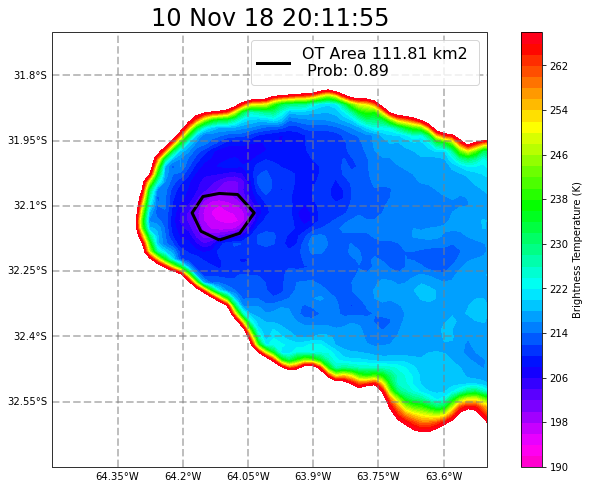

(array([100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102,
       102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 104,
       104, 104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105,
       105, 105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 107, 107,
       107, 107, 107, 107, 107]), array([100, 101, 102,  98,  99, 100, 101, 102, 103, 104,  98,  99, 100,
       101, 102, 103, 104,  97,  98,  99, 100, 101, 102, 103, 104,  97,
        98,  99, 100, 101, 102, 103, 104, 105,  97,  98,  99, 100, 101,
       102, 103, 104, 105,  98,  99, 100, 101, 102, 103, 104,  98,  99,
       100, 101, 102, 103, 104]))
[0.17984771728515625, 0.2840538024902344, 0.4297637939453125, 0.5129241943359375, 0.5193214416503906, 0.3618354797363281, 0.06727218627929688, -0.2908668518066406, -0.5661964416503906, -0.63433837890625, -0.5318832397460938, -0.3343772888183594, -0.11215591430664062, 0.07770156860351562, 0.22598648071289062, 0.3429412841796875, 0.4686393737792969, 0.655

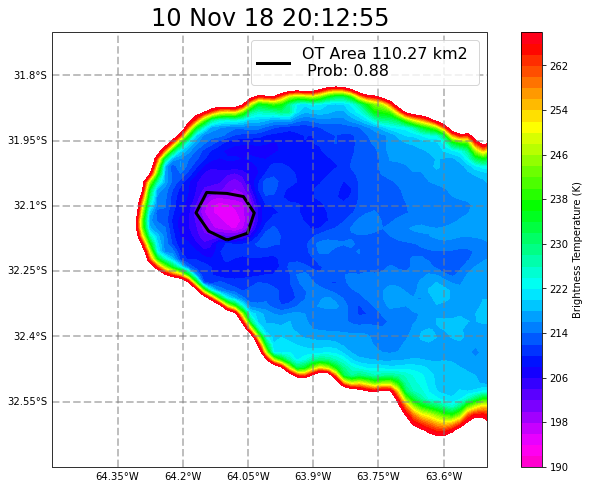

(array([100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102,
       102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 104,
       104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105,
       105, 105, 106, 106, 106, 106, 106, 106, 107, 107, 107, 107, 107,
       107]), array([101, 102, 103,  99, 100, 101, 102, 103, 104, 105,  99, 100, 101,
       102, 103, 104, 105,  98,  99, 100, 101, 102, 103, 104, 105,  98,
        99, 100, 101, 102, 103, 104, 105,  98,  99, 100, 101, 102, 103,
       104, 105,  99, 100, 101, 102, 103, 104,  99, 100, 101, 102, 103,
       104]))
[0.20587921142578125, 0.31090545654296875, 0.4265403747558594, 0.4466400146484375, 0.4214668273925781, 0.29834747314453125, 0.072113037109375, -0.23093414306640625, -0.5061111450195312, -0.6480712890625, -0.6272010803222656, -0.4521369934082031, -0.20870590209960938, 0.010822296142578125, 0.16551971435546875, 0.23978805541992188, 0.2680816650390625, 0.29742431640625, 0.3750267028808594, 0.551

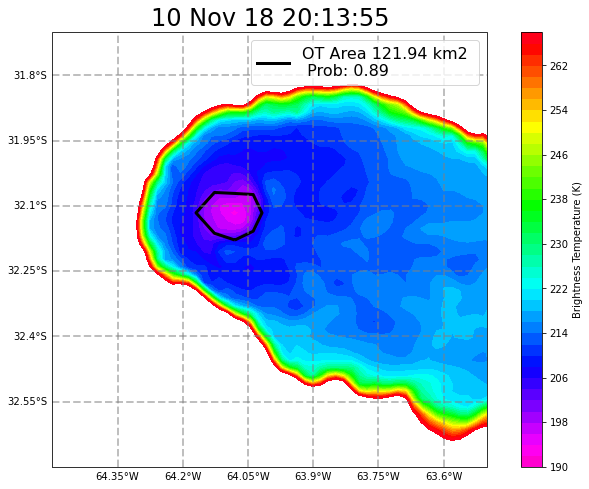

(array([100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102,
       102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 104,
       104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105,
       105, 105, 106, 106, 106, 106, 106, 106, 107, 107, 107, 107]), array([102, 103, 104, 100, 101, 102, 103, 104, 105, 106, 100, 101, 102,
       103, 104, 105, 106,  99, 100, 101, 102, 103, 104, 105, 106,  99,
       100, 101, 102, 103, 104, 105, 106,  99, 100, 101, 102, 103, 104,
       105, 106, 100, 101, 102, 103, 104, 105, 100, 101, 102, 103]))
[0.26470184326171875, 0.40387725830078125, 0.5349464416503906, 0.4835853576660156, 0.3518524169921875, 0.13496780395507812, -0.13048553466796875, -0.3929786682128906, -0.5825653076171875, -0.6387481689453125, -0.5572891235351562, -0.3626365661621094, -0.13768768310546875, 0.03440093994140625, 0.12782669067382812, 0.14378738403320312, 0.13418960571289062, 0.14982986450195312, 0.18632125854492188, 0.23793411254882812, 0.3486900

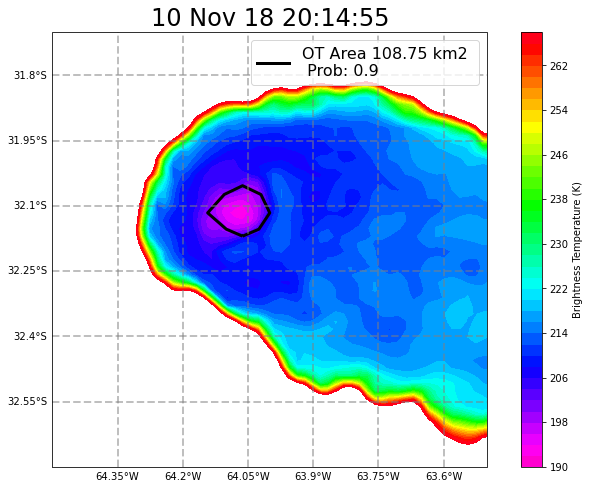

(array([], dtype=int64), array([], dtype=int64))
(array([100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102,
       102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 103,
       104, 104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105,
       105, 105, 105, 106, 106, 106, 106, 106, 106, 106, 107, 107, 107,
       107]), array([102, 103, 104, 100, 101, 102, 103, 104, 105, 106, 100, 101, 102,
       103, 104, 105, 106,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        99, 100, 101, 102, 103, 104, 105, 106,  99, 100, 101, 102, 103,
       104, 105, 106, 100, 101, 102, 103, 104, 105, 106, 100, 101, 102,
       103]))
[0.27143096923828125, 0.4239501953125, 0.5867729187011719, 0.5679054260253906, 0.4520454406738281, 0.22535324096679688, -0.07316970825195312, -0.3858375549316406, -0.6329879760742188, -0.7432365417480469, -0.7003555297851562, -0.513885498046875, -0.24121856689453125, 0.0458526611328125, 0.26583099365234375, 0.3523368835449219, 0.309112548828125

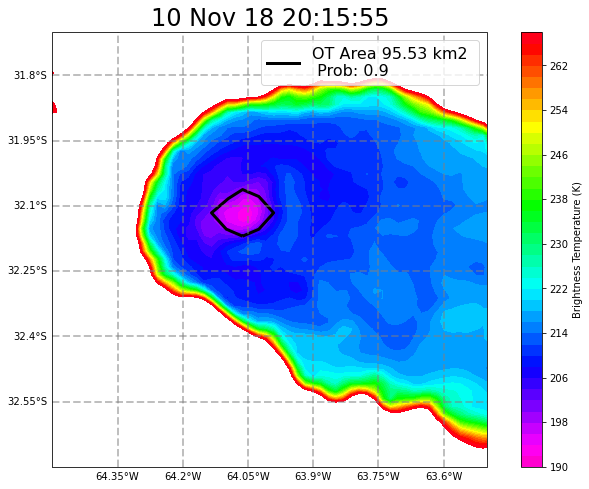

(array([100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102,
       102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 104,
       104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105,
       105, 106, 106, 106, 106, 106, 106, 107, 107, 107, 107]), array([103, 104, 105, 101, 102, 103, 104, 105, 106, 107, 101, 102, 103,
       104, 105, 106, 107, 100, 101, 102, 103, 104, 105, 106, 107, 100,
       101, 102, 103, 104, 105, 106, 107, 100, 101, 102, 103, 104, 105,
       106, 101, 102, 103, 104, 105, 106, 101, 102, 103, 104]))
[0.27459716796875, 0.4199409484863281, 0.5524444580078125, 0.48247528076171875, 0.32032012939453125, 0.0718841552734375, -0.21164321899414062, -0.46897125244140625, -0.6437187194824219, -0.6929855346679688, -0.6228713989257812, -0.456512451171875, -0.2361297607421875, -0.00833892822265625, 0.18162155151367188, 0.2956047058105469, 0.32250213623046875, 0.2678031921386719, 0.17638778686523438, 0.09894943237304688, 0.07007980346679688, 0.1

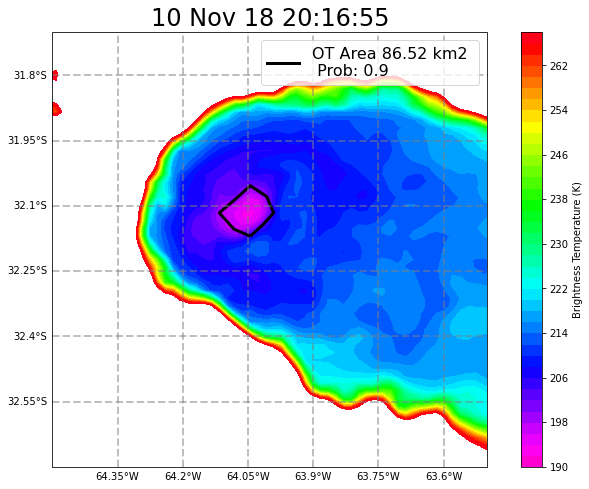

(array([100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102,
       102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 104,
       104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105,
       105, 105, 106, 106, 106, 106, 106, 106, 107, 107, 107, 107]), array([103, 104, 105, 101, 102, 103, 104, 105, 106, 107, 101, 102, 103,
       104, 105, 106, 107, 100, 101, 102, 103, 104, 105, 106, 107, 100,
       101, 102, 103, 104, 105, 106, 107, 100, 101, 102, 103, 104, 105,
       106, 107, 101, 102, 103, 104, 105, 106, 101, 102, 103, 104]))
[0.2863311767578125, 0.42908477783203125, 0.5431289672851562, 0.44567108154296875, 0.2753181457519531, 0.04813385009765625, -0.19872283935546875, -0.4229888916015625, -0.5830574035644531, -0.6441688537597656, -0.5982398986816406, -0.4534034729003906, -0.2559089660644531, -0.057464599609375, 0.10639190673828125, 0.21144485473632812, 0.262603759765625, 0.2700653076171875, 0.2360076904296875, 0.168121337890625, 0.104282379150390

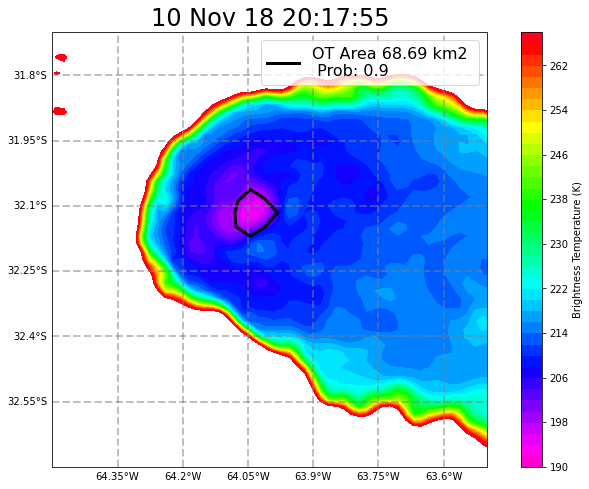

(array([100, 100, 100, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102,
       102, 102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 104,
       104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105,
       105, 106, 106, 106, 106, 106, 107, 107, 107]), array([104, 105, 106, 102, 103, 104, 105, 106, 107, 108, 102, 103, 104,
       105, 106, 107, 108, 101, 102, 103, 104, 105, 106, 107, 108, 101,
       102, 103, 104, 105, 106, 107, 108, 101, 102, 103, 104, 105, 106,
       107, 102, 103, 104, 105, 106, 102, 103, 104]))
[0.332427978515625, 0.48186492919921875, 0.5628509521484375, 0.3818206787109375, 0.1453857421875, -0.10009384155273438, -0.3198661804199219, -0.4863471984863281, -0.5891036987304688, -0.62078857421875, -0.5692596435546875, -0.4309272766113281, -0.2411041259765625, -0.044490814208984375, 0.1154937744140625, 0.20680618286132812, 0.24160003662109375, 0.2415924072265625, 0.22256088256835938, 0.19659805297851562, 0.16696548461914062, 0.13474273681640625, 0.101

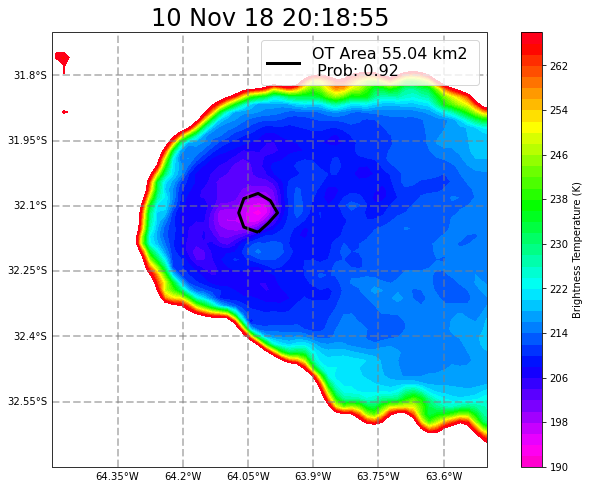

(array([100, 100, 101, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102,
       102, 102, 102, 103, 103, 103, 103, 103, 103, 103, 103, 104, 104,
       104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 105, 106,
       106, 106, 106, 106, 107, 107, 107]), array([104, 105, 102, 103, 104, 105, 106, 107, 108, 102, 103, 104, 105,
       106, 107, 108, 101, 102, 103, 104, 105, 106, 107, 108, 101, 102,
       103, 104, 105, 106, 107, 101, 102, 103, 104, 105, 106, 107, 102,
       103, 104, 105, 106, 102, 103, 104]))
[0.35419464111328125, 0.5267143249511719, 0.6437225341796875, 0.4729766845703125, 0.22200775146484375, -0.0521392822265625, -0.2995262145996094, -0.4812507629394531, -0.5955543518066406, -0.6439895629882812, -0.6041488647460938, -0.4603080749511719, -0.247406005859375, -0.016815185546875, 0.16500473022460938, 0.24533843994140625, 0.24150466918945312, 0.1902618408203125, 0.13612747192382812, 0.11552047729492188, 0.12468338012695312, 0.14903640747070312, 0.17079544067382812, 0

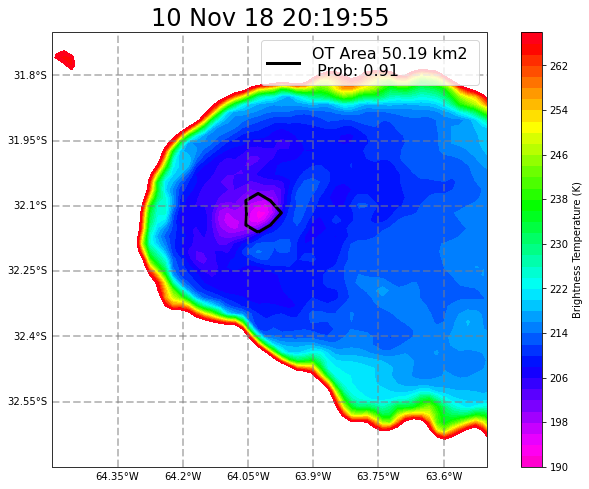

(array([100, 100, 101, 101, 101, 101, 101, 101, 102, 102, 102, 102, 102,
       102, 103, 103, 103, 103, 103, 103, 103, 104, 104, 104, 104, 104,
       104, 104, 105, 105, 105, 105, 105, 105, 106, 106, 106, 106, 107]), array([105, 107, 103, 104, 105, 106, 107, 108, 103, 104, 105, 106, 107,
       108, 102, 103, 104, 105, 106, 107, 108, 102, 103, 104, 105, 106,
       107, 108, 102, 103, 104, 105, 106, 107, 103, 104, 105, 106, 103]))
[0.33911895751953125, 0.4856986999511719, 0.5554580688476562, 0.3630714416503906, 0.123321533203125, -0.12005615234375, -0.3290824890136719, -0.473968505859375, -0.5519828796386719, -0.5660934448242188, -0.5150108337402344, -0.400146484375, -0.23802566528320312, -0.053070068359375, 0.11388397216796875, 0.22436141967773438, 0.26569366455078125, 0.23885726928710938, 0.17360305786132812, 0.10467910766601562, 0.058086395263671875, 0.050689697265625, 0.071563720703125, 0.103973388671875, 0.135772705078125, 0.16511154174804688, 0.22669601440429688, 0.360595703125

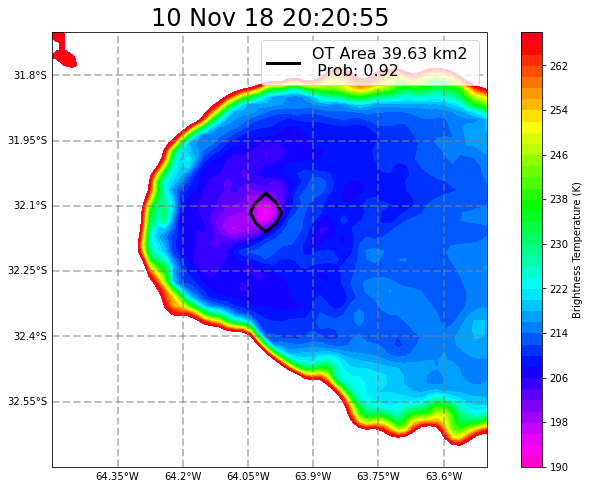

(array([101, 101, 101, 101, 102, 102, 102, 102, 103, 103, 103, 103, 103,
       103, 104, 104, 104, 104, 104, 104, 104, 105, 105, 105, 105, 105,
       105, 105, 106, 106, 106, 106, 107, 107, 107]), array([103, 104, 105, 106, 104, 105, 106, 107, 103, 104, 105, 106, 107,
       108, 102, 103, 104, 105, 106, 107, 108, 102, 103, 104, 105, 106,
       107, 108, 103, 104, 105, 106, 103, 104, 105]))
[0.24349212646484375, 0.35101318359375, 0.40897369384765625, 0.2845191955566406, 0.13470840454101562, -0.008861541748046875, -0.14004898071289062, -0.25994110107421875, -0.3730812072753906, -0.4775505065917969, -0.5421333312988281, -0.5317497253417969, -0.4252433776855469, -0.21998977661132812, 0.026554107666015625, 0.244293212890625, 0.37255859375, 0.3735084533691406, 0.2912445068359375, 0.18497467041015625, 0.09241485595703125, 0.0380706787109375, 0.0150146484375, 0.014820098876953125, 0.054531097412109375, 0.156341552734375, 0.3376197814941406, 0.6035804748535156, 0.9156494140625, 1.2189292907

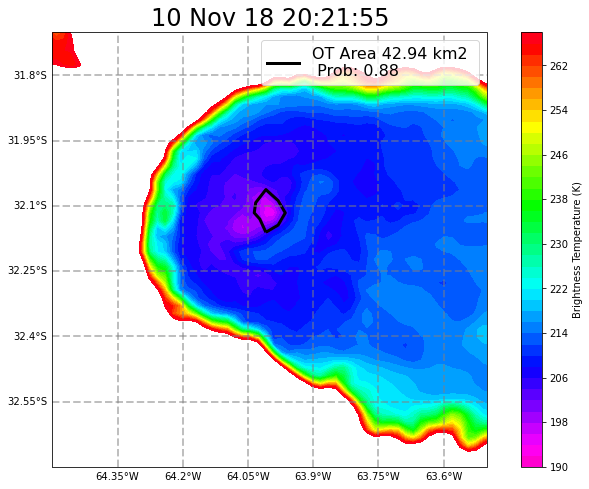

(array([101, 101, 101, 102, 102, 102, 102, 103, 103, 103, 103, 103, 104,
       104, 104, 104, 104, 104, 105, 105, 105, 105, 105, 105, 106, 106,
       107]), array([105, 106, 107, 104, 105, 106, 107, 104, 105, 106, 107, 108, 103,
       104, 105, 106, 107, 108, 102, 103, 104, 105, 106, 107, 103, 104,
       103]))
[0.22818756103515625, 0.3159294128417969, 0.32540130615234375, 0.14344406127929688, -0.03753662109375, -0.1547698974609375, -0.20529556274414062, -0.20954132080078125, -0.22174072265625, -0.28591156005859375, -0.37125396728515625, -0.4300422668457031, -0.4217414855957031, -0.3199462890625, -0.14751052856445312, 0.057628631591796875, 0.24639129638671875, 0.37210845947265625, 0.40894317626953125, 0.3477821350097656, 0.22552490234375, 0.09048080444335938, -0.009372711181640625, -0.03864288330078125, -0.0119781494140625, 0.0500335693359375, 0.15309906005859375, 0.32523345947265625, 0.6574134826660156, 1.2031173706054688, 1.8028106689453125, 2.232410430908203, 2.2227020263671875,

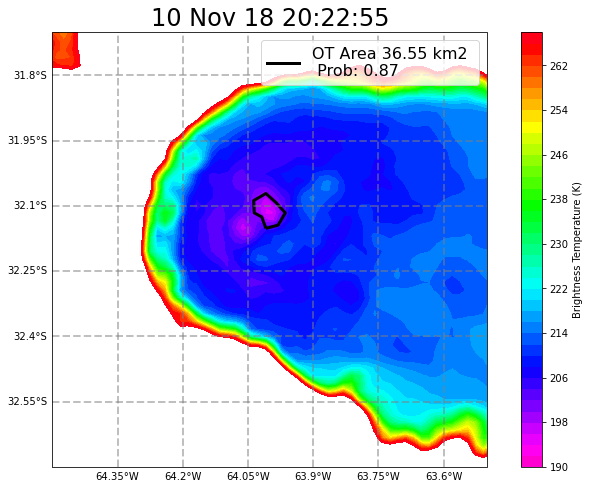

(array([101, 101, 101, 102, 102, 102, 103, 103, 103, 103, 104, 104, 104,
       104, 105, 105, 105, 105, 105, 105, 105, 106, 106, 106, 107]), array([105, 106, 107, 105, 106, 107, 105, 106, 107, 108, 105, 106, 107,
       108, 102, 103, 104, 105, 106, 107, 108, 103, 104, 107, 103]))
[0.1961669921875, 0.3138236999511719, 0.46590423583984375, 0.5169410705566406, 0.4894828796386719, 0.3396110534667969, 0.10499954223632812, -0.15295028686523438, -0.3596076965332031, -0.4568977355957031, -0.4661750793457031, -0.4253120422363281, -0.35874176025390625, -0.28490447998046875, -0.21179580688476562, -0.14291000366210938, -0.07410049438476562, 0.001125335693359375, 0.09099960327148438, 0.19643783569335938, 0.2873573303222656, 0.3304634094238281, 0.310546875, 0.22667694091796875, 0.11693954467773438, 0.0252532958984375, -0.020153045654296875, -0.001598358154296875, 0.07222366333007812, 0.19441986083984375, 0.3915824890136719, 0.695770263671875, 1.12744140625, 1.6634445190429688, 2.1177597045898438, 

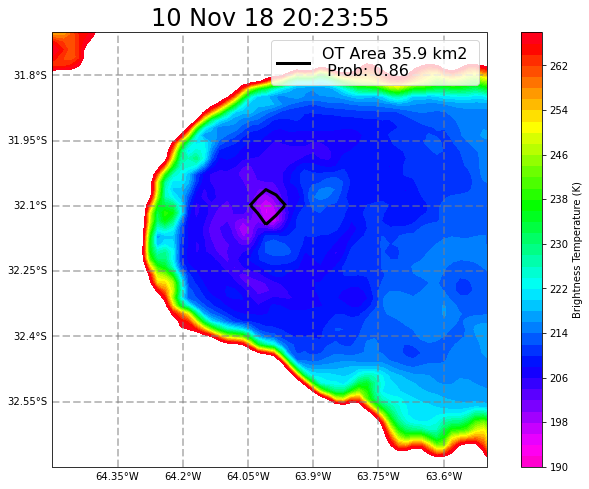

(array([102, 102, 103, 103, 103, 104, 104, 104, 105, 105, 105, 105, 106,
       106]), array([105, 106, 105, 106, 107, 105, 106, 107, 105, 106, 107, 108, 106,
       107]))
[0.2805328369140625, 0.4034767150878906, 0.4349212646484375, 0.18257522583007812, -0.14475631713867188, -0.4529151916503906, -0.6533927917480469, -0.6821136474609375, -0.5670623779296875, -0.3641395568847656, -0.14881515502929688, 0.0111236572265625, 0.09822845458984375, 0.11584091186523438, 0.10009384155273438, 0.09006118774414062, 0.10373687744140625, 0.14702224731445312, 0.19850921630859375, 0.23204421997070312, 0.22979736328125, 0.18269729614257812, 0.10836410522460938, 0.033046722412109375, -0.00911712646484375, 0.010715484619140625, 0.0924072265625, 0.2348480224609375, 0.4619255065917969, 0.7978515625, 1.2430877685546875, 1.7531242370605469, 2.1273193359375, 2.142566680908203, 1.6420974731445312, 0.5787506103515625, -0.7225418090820312, -1.8602333068847656, -2.4985198974609375, -1.9467315673828125, -1.25387573

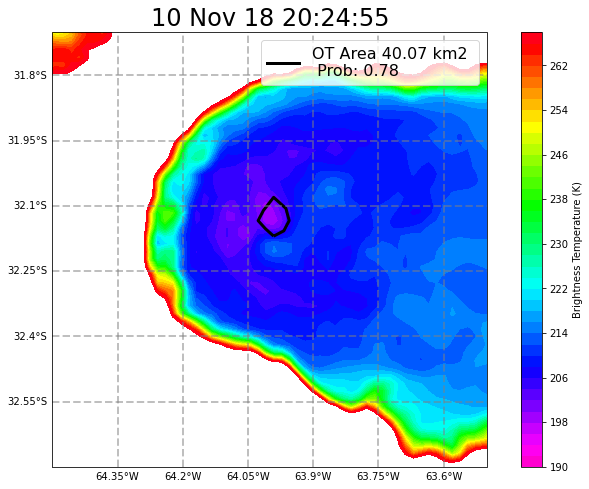

(array([103, 104, 104, 105, 105, 106, 106, 107, 107, 107, 108, 108, 108,
       109, 109]), array([102, 101, 102, 101, 102, 102, 103, 102, 103, 104, 102, 103, 104,
       102, 103]))
[0.10384368896484375, 0.14795303344726562, 0.15821075439453125, 0.07250595092773438, -0.011829376220703125, -0.051609039306640625, -0.055118560791015625, -0.042327880859375, -0.0285186767578125, -0.022037506103515625, -0.0081634521484375, 0.025173187255859375, 0.05640411376953125, 0.061397552490234375, 0.039325714111328125, -0.000942230224609375, -0.035022735595703125, -0.0403289794921875, -0.016956329345703125, 0.0340576171875, 0.13063430786132812, 0.2987556457519531, 0.5776329040527344, 0.9828262329101562, 1.4220962524414062, 1.768310546875, 1.8625717163085938, 1.5806007385253906, 0.9683036804199219, 0.14069366455078125, -0.6809043884277344, -1.2825965881347656, -1.5864944458007812, -1.5802078247070312, -1.3774032592773438, -1.1071624755859375, -0.8343582153320312, -0.5993118286132812, -0.408126831054687

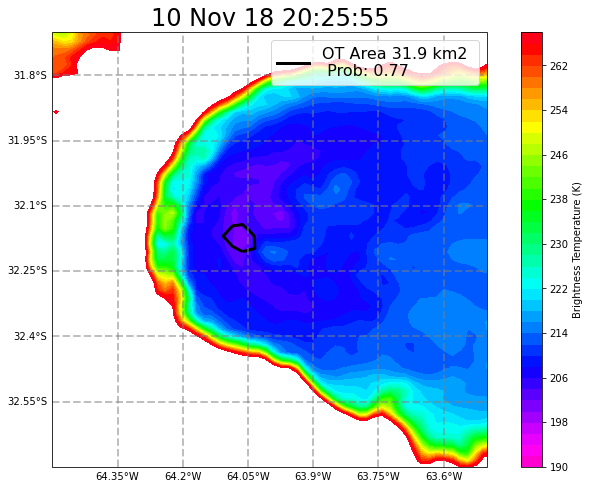

In [16]:
df_list = []

for file in files[1:26]:
    ds = xr.open_dataset(file).squeeze()
    df = process_ot_data(file)
    
    ir_vals = ds.ir_brightness_temperature.values
    
    plt.figure(figsize=(12,8))
    
    lon = ds.longitude.values
    lat = ds.latitude.values

    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ax.set_extent((-64.5, -63.5, -32.7, -31.7))
    cf = plt.contourf(lon, lat, ir_vals, np.arange(190, 270, 2), cmap='gist_rainbow_r')
    plt.colorbar(cf, label='Brightness Temperature (K)')
    
    df_ex = df[df.mintb == np.nanmin(df.mintb.values)]

    df_ex.plot(ax=ax, facecolor="none", edgecolor='black', lw=3,)

    ax.plot(0, 0, color='black', lw=3, label=f'OT Area {np.round(df_ex.area_polygon.values[0], 2)} km2 \n Prob: {np.round(df_ex.prob.values[0], 2)}')
    plt.legend(fontsize=16)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False

    plt.title(pd.to_datetime(df.time.values[0]).strftime('%d %b %y %H:%M:%S'), fontsize=24)
    plt.savefig(pd.to_datetime(df.time.values[0]).strftime('compare_plots/Nov10/%b_%d_%y_%H%M.%S.png'), dpi=300)
    plt.show()
    plt.close()
    
    df_list.append(df)

In [17]:
nov_10_df = pd.concat(df_list)

df = nov_10_df

In [18]:
df_list = []
for time in np.unique(df.time):
    df_sub = df[df.time == time]
    
    df_list.append(df_sub[df_sub.mintb == np.nanmin(df_sub.mintb.values)])

In [19]:
nov_10_df_filtered = pd.concat(df_list)
df = nov_10_df_filtered.reset_index()

In [20]:
radial_cols = ['n_radial', 'ne_radial', 'e_radial', 'se_radial', 's_radial', 'sw_radial', 'w_radial', 'nw_radial']
radial_del2 = ['n_radial_del2', 'ne_radial_del2', 'e_radial_del2', 'se_radial_del2', 's_radial_del2', 'sw_radial_del2', 'w_radial_del2', 'nw_radial_del2']
radial_tb = ['n_tb', 'ne_tb', 'e_tb', 'se_tb', 's_tb', 'sw_tb', 'w_tb', 'nw_tb']

In [21]:
df_sub = df[df.index == 10]

In [22]:
radials = df_sub[radial_cols].values[0]

In [23]:
del2 = df_sub[radial_del2].values[0]

In [24]:
tb = df_sub[radial_tb].values[0]

In [72]:
mean = np.mean(radials)

In [73]:
std = np.std(radials)

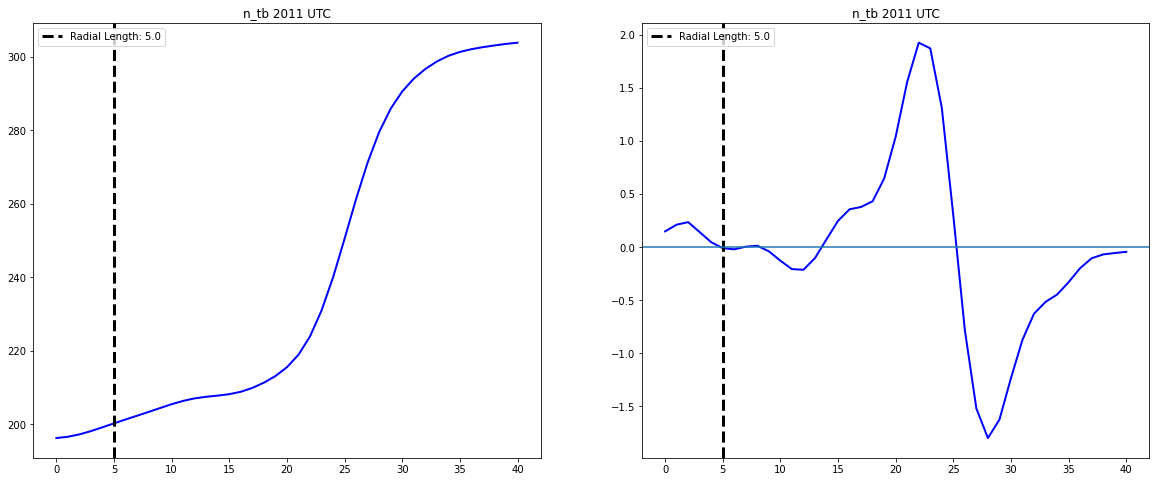

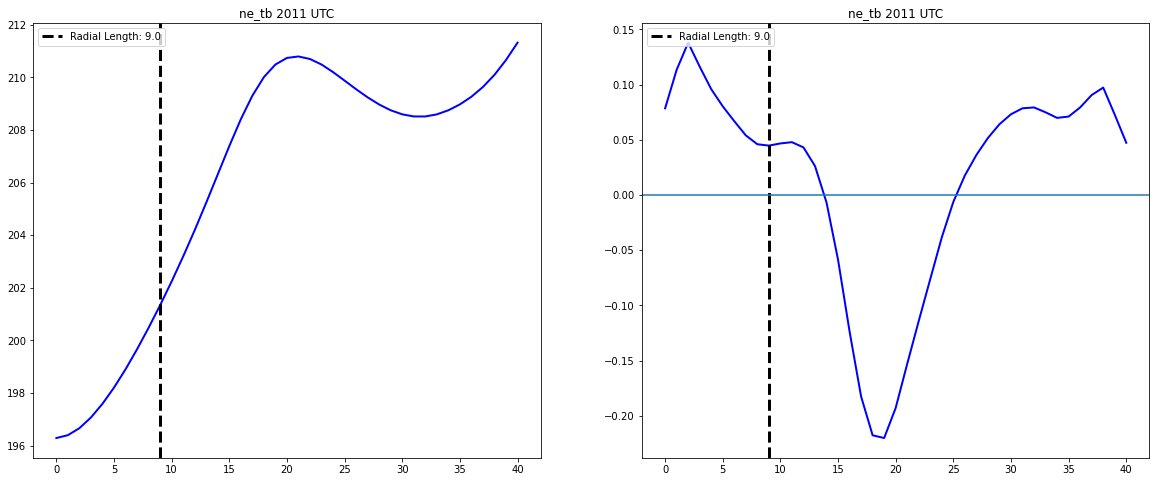

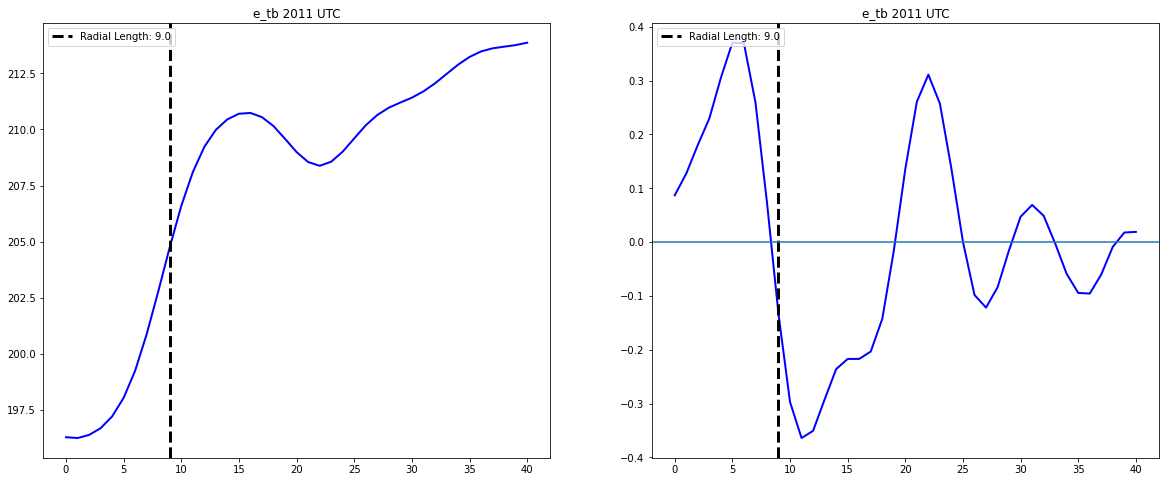

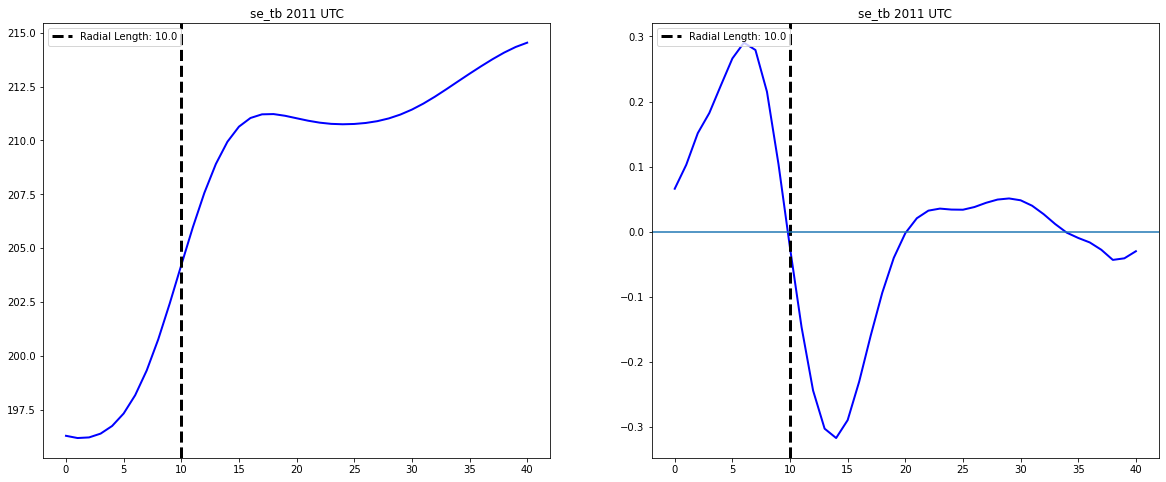

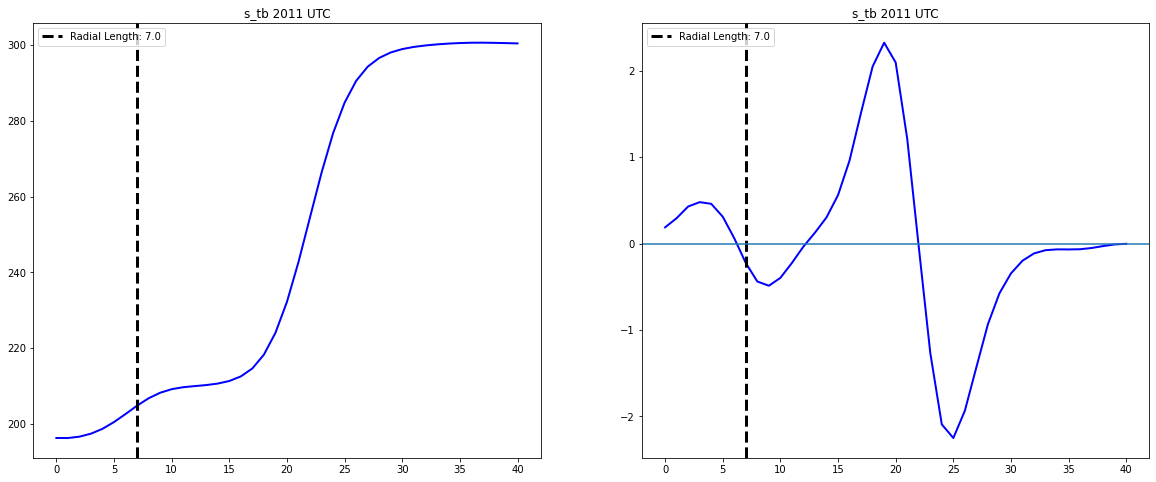

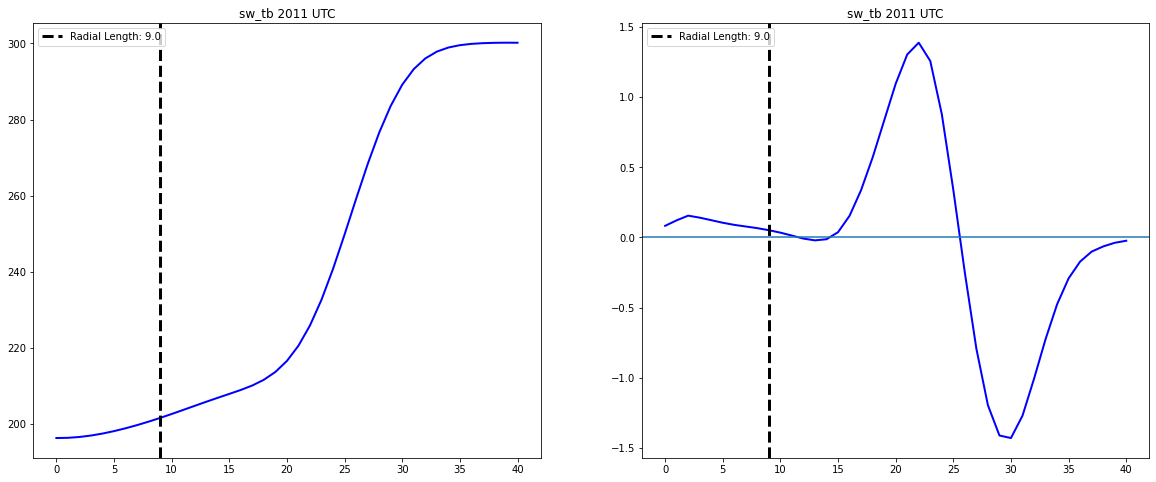

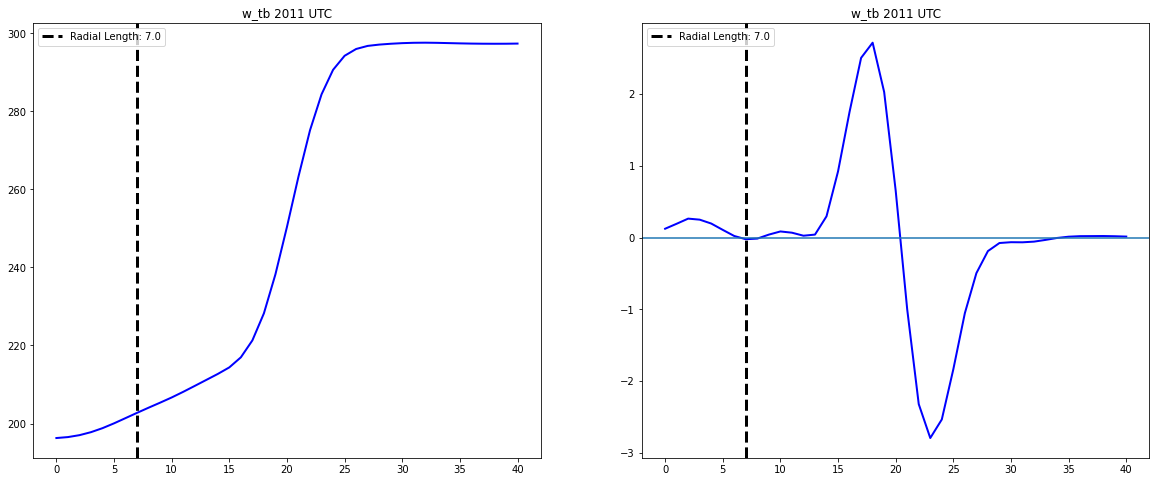

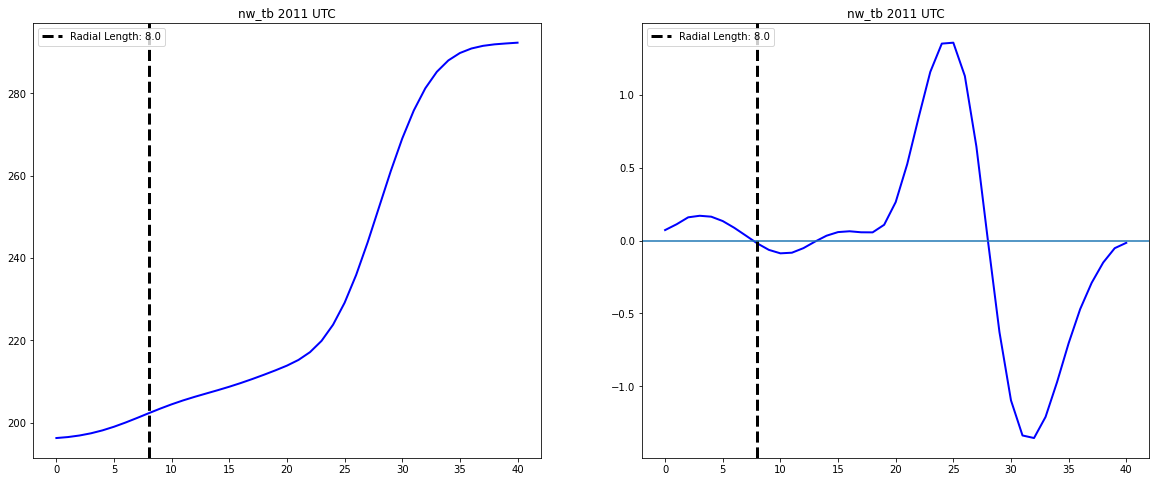

In [74]:
for i in range(len(radial_tb)):
    fig = plt.figure(figsize=(20,8))
    
    ax1 = plt.subplot(121)
    ax1.plot(tb[i], color='blue', linewidth=2)
    plt.axvline(radials[i], color='black', linewidth=3, linestyle='--', label=f'Radial Length: {radials[i]}')
    plt.title(radial_tb[i] + df_sub.time[df_sub.index[0]].strftime(' %H%M UTC'))
    plt.legend(loc='upper left')
    
    ax2 = plt.subplot(122)
    ax2.plot(del2[i], color='blue', linewidth=2)
    plt.axvline(radials[i], color='black', linewidth=3, linestyle='--', label=f'Radial Length: {radials[i]}')
    plt.axhline(0)
    plt.title(radial_tb[i] + df_sub.time[df_sub.index[0]].strftime(' %H%M UTC'))
    plt.legend(loc='upper left')
    
    plt.plot()
    plt.show()
    plt.close()

In [27]:
df.index = df.time

In [28]:
import matplotlib.dates as mdates

In [32]:
months = mdates.MinuteLocator() 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as md

In [115]:
df = df[df.prob > .8]
df['datetime'] = pd.to_numeric(df.time.dt.strftime('%H%M'))
ota = df.area_polygon.values
times = df.datetime.values

trop_temp = df.tropopause_temperature.values
mintb = df.mintb.values

trop_hgt = df.tropopause_height.values
ct_height = df.cloudtop_height.values

In [116]:
trop_temp_vals = []
trop_hgt_vals = []
ct_hgt_vals =[]
for i in range(len(trop_temp)):
    trop_temp_vals.append(trop_temp[i][0])
    trop_hgt_vals.append(trop_hgt[i][0])
    ct_hgt_vals.append(ct_height[i][0])

In [118]:
for timestamp in df.datetime.values:
    df_sub = df[df.datetime == timestamp]
    
    plt.figure(figsize=(12,8))
    ax = plt.subplot(311)

    ax.plot(times, ota, linewidth=3, color='black')
    ax.scatter(df_sub.datetime, df_sub.area_polygon, s=80, color='black')
    
    plt.ylim(0,150)
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=12)

    plt.ylabel('OTA \n $km^{2}$', fontsize=16)
    
    ax2 = plt.subplot(312)
    ax2.plot(times, trop_temp_vals, linewidth=3, color='black', linestyle='--', label='Tropopause Temperature')
    ax2.plot(times, mintb, linewidth=3, color='blue', label='OT Minimum Brightness Temperature')
    
    ax2.scatter(df_sub.datetime, df_sub.mintb, s=80, color='black')
    
    plt.ylabel('OT Min \n  Brightness Temp (K)', fontsize=16)
    
    plt.legend(loc='upper right')
    
    ax3 = plt.subplot(313)
    ax3.plot(times, trop_hgt_vals, linewidth=3, color='black', linestyle='--', label='Tropause Height')
    ax3.plot(times, ct_hgt_vals, linewidth=3, color='red', label='OT Cloud Top Height')
    ax3.scatter(df_sub.datetime, df_sub.cloudtop_height.values[0], s=80, color='black')
    
    plt.ylabel('OT Cloud Top \n Height (km)', fontsize=16)
    plt.xlabel('Time', fontsize=16)
    
    plt.legend(loc='upper right')


    plt.suptitle(f'10 November 2018 Supercell \n {df_sub.datetime.values[0]} UTC', fontsize=24)
    plt.savefig(f'compare_plots/time_series_{timestamp}.png', dpi=200)
    plt.close()

In [81]:
trop_temp = df.tropopause_temperature.mean()

In [110]:
df.prob

time
2018-11-10 20:07:55.000000512    0.82
2018-11-10 20:08:55.000000512    0.81
2018-11-10 20:11:55.000000512    0.89
2018-11-10 20:12:55.000000512    0.88
2018-11-10 20:13:55.000000512    0.89
2018-11-10 20:14:55.000000512    0.90
2018-11-10 20:15:55.000000512    0.90
2018-11-10 20:16:55.000000512    0.90
2018-11-10 20:17:55.000000512    0.90
2018-11-10 20:18:55.000000512    0.92
2018-11-10 20:19:55.000000512    0.91
2018-11-10 20:20:55.000000512    0.92
2018-11-10 20:21:55.000000512    0.88
2018-11-10 20:22:55.000000512    0.87
2018-11-10 20:23:55.000000512    0.86
Name: prob, dtype: float64

Text(0.5, 1.0, '10 November 2018 Supercell \n OT Minimum Brightness Temperature')

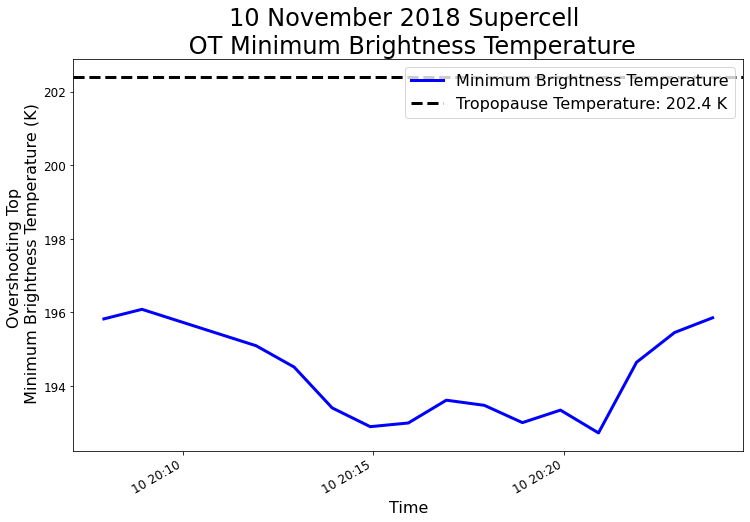

In [90]:
plt.figure(figsize=(12,8))
df[df.prob > .8].mintb.plot(linewidth=3, color='blue', label='Minimum Brightness Temperature')
#plt.ylim(0,150)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.axhline(trop_temp, label=f'Tropopause Temperature: {np.round(trop_temp,2)} K', linewidth=3, color='black', linestyle='--')

plt.ylabel('Overshooting Top \n Minimum Brightness Temperature (K)', fontsize=16)
plt.xlabel('Time', fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.title('10 November 2018 Supercell \n OT Minimum Brightness Temperature', fontsize=24)



In [ ]:
df

In [92]:
trop_height = df.tropopause_height.mean()

Text(0.5, 1.0, '10 November 2018 Supercell \n OT Cloud Top Height')

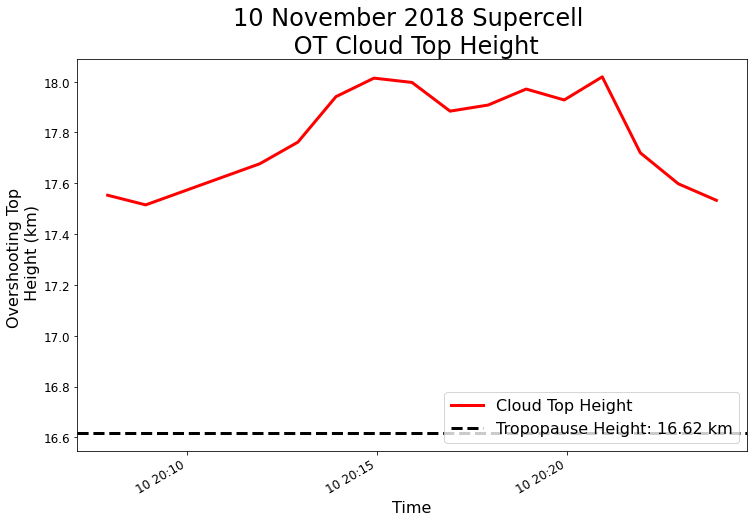

In [99]:
plt.figure(figsize=(12,8))
df[df.prob > .8].cloudtop_height.plot(linewidth=3, color='red', label='Cloud Top Height')
#plt.ylim(0,150)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

ax.xaxis.set_minor_locator(AutoMinorLocator())
plt.axhline(trop_height, label=f'Tropopause Height: {np.round(trop_height,2)} km', linewidth=3, color='black', linestyle='--')

plt.ylabel('Overshooting Top \n Height (km)', fontsize=16)
plt.xlabel('Time', fontsize=16)

plt.legend(loc='lower right', fontsize=16)

plt.title('10 November 2018 Supercell \n OT Cloud Top Height', fontsize=24)

In [ ]:
df_list = []
for file in files:
    df_list.append(process_ot_data(file))

In [27]:
nov_10_df = pd.concat(df_list)

df = nov_10_df

In [105]:
df_list = []
for time in np.unique(df.time):
    df_sub = df[df.time == time]
    
    df_list.append(df_sub[df_sub.mintb == np.nanmin(df_sub.mintb.values)])

AttributeError: 'GeoDataFrame' object has no attribute 'time'

In [96]:
nov_10_df_filtered = pd.concat(df_list)
df = nov_10_df_filtered

In [97]:
df.index = pd.to_datetime(df.time)

In [98]:
df = df.drop(columns='time')

In [100]:
df.tropopause_height.values

array([16.61300087, 16.62100029, 16.62100029, 16.61400032, 16.62000084,
       16.61900139, 16.61900139, 16.6230011 , 16.61300087, 16.61100006,
       16.62100029, 16.62200165, 16.625     , 16.62800026, 16.62800026,
       16.60700035, 16.60900116, 16.60900116, 16.61000061, 16.61300087,
       16.61300087, 16.61800003, 16.62100029, 16.61400032, 16.62000084,
       16.61800003])

In [101]:
df = df[df.prob > .8]

In [103]:
df.to_csv('revised_ot_10_Nov_2007_2024.csv')

In [6]:
import pandas as pd
df = pd.read_csv('revised_ot_10_Nov_2000_2026.csv', index_col='time', parse_dates=True)

In [7]:
df_sub = df[df.time == df.time[11]]

AttributeError: 'DataFrame' object has no attribute 'time'

---
### Plot Vis satellite imagery from this case

In [39]:
import metpy
import glob
import xarray as xr
from shapely import wkt

In [99]:
def plot_vis(file, ot_df=df, extent=(-65, -63, -33, -31)):
    
    # Use metpy to read in the file and assign crs
    dat = xr.open_dataset(file).metpy.parse_cf('Rad')
    
    # Pull out the crs, and coordinates
    proj = dat.metpy.cartopy_crs
    x = dat['x']
    y = dat['y']
    
    # Deal with matching times
    time = pd.to_datetime(file[-18:-3], format='%Y%m%d_%H%M%S')
    df_sub = ot_df[(ot_df.minute == time.minute) & (ot_df.mintb == np.min(ot_df.mintb))]
    
    # Setup figure
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=proj)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':', edgecolor='black')
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=2, edgecolor='black')

    im = ax.imshow(dat, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper', transform=proj, cmap='gist_gray')

    plt.colorbar(im, shrink=.7, label='Radiance')

    df_sub.plot(ax=ax, transform=ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=3)

    plt.title(time, fontsize=24)

    ax.plot(0, 0, color='red', lw=3, label=f'OT Area {np.round(df_sub.area_polygon.values[0], 2)} km2')

    ax.set_extent((-64.5, -63.5, -32.7, -31.7), crs=ccrs.PlateCarree())

    plt.legend(loc='upper right', fontsize=16)
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    plt.tight_layout()
    
    plt.savefig(time.strftime('Vis_OT_%Y%m%d_%H%M.png'), dpi=400)

In [100]:
def read_ot_df(file):
    
    df = pd.read_csv(file, index_col='time', parse_dates=True)
    
    #df['minute'] = df.index.minute

    df['geometry'] = df['geometry'].apply(wkt.loads)
    geo_df = gpd.GeoDataFrame(df, geometry='geometry')
    
    geo_df = geo_df[(geo_df.area_polygon >10) & (geo_df.area_polygon < 500) & (geo_df.prob > .7)]
    
    return geo_df

In [101]:
file = '../overshooting_tops/ot_output/20181110/20181110_2022.csv'

In [102]:
df = read_ot_df(file)
df['time'] = pd.to_datetime(df.index)
df['minute'] = df.time.dt.minute

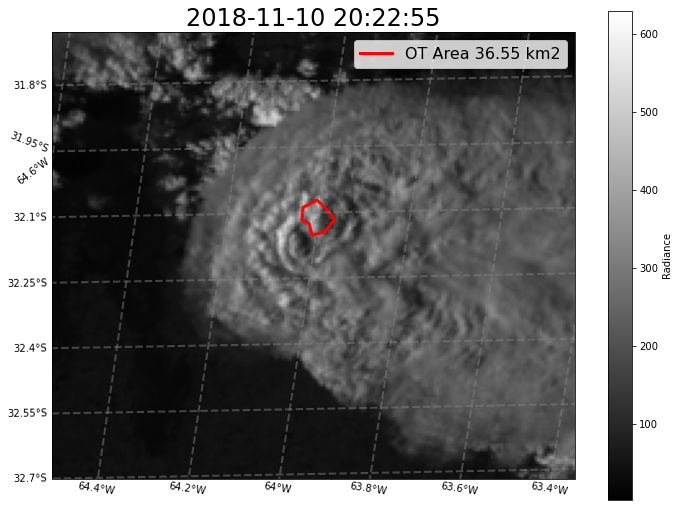

In [103]:
plot_vis(sat_files[22], ot_df=df)

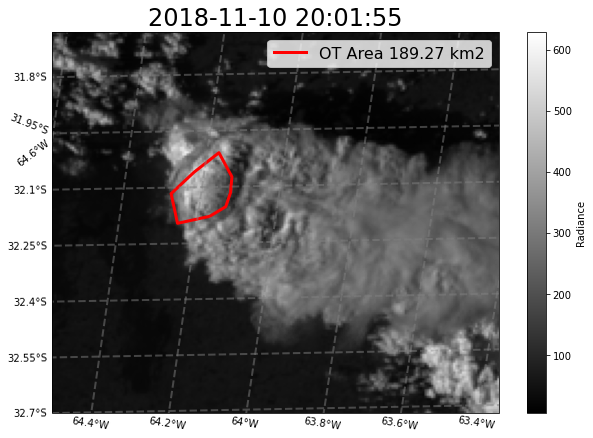

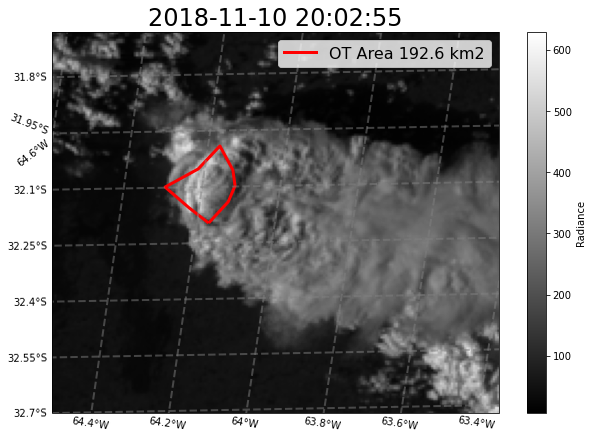

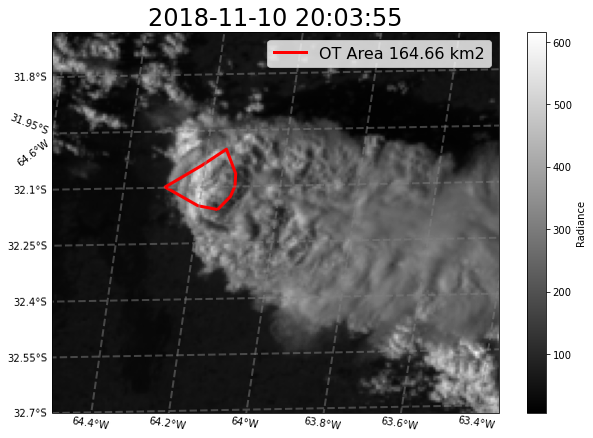

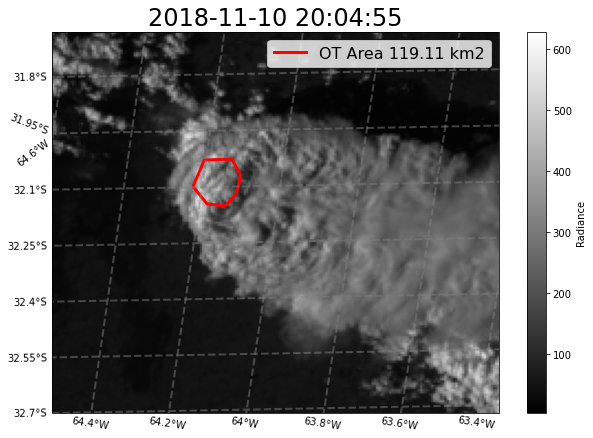

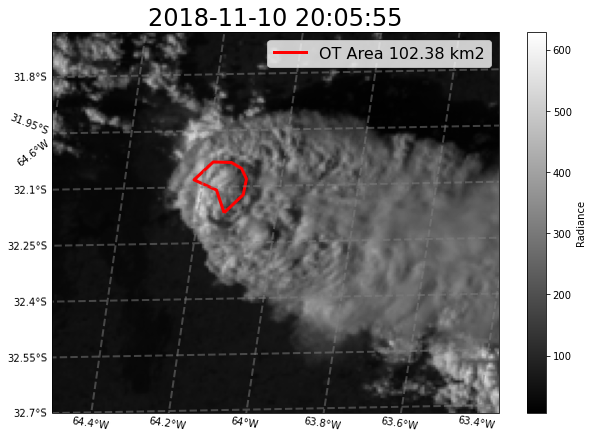

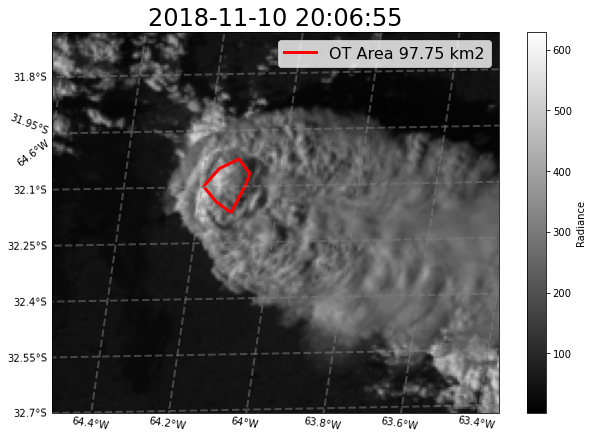

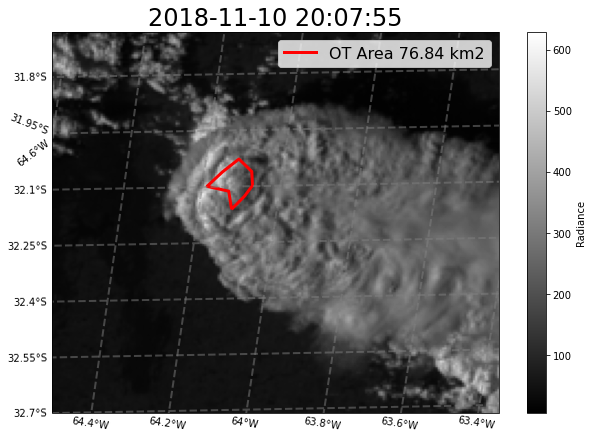

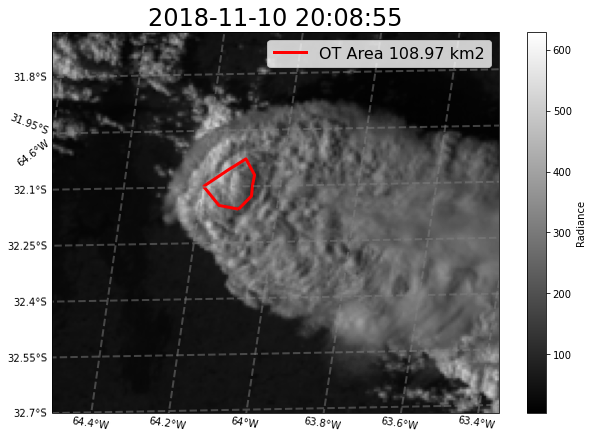

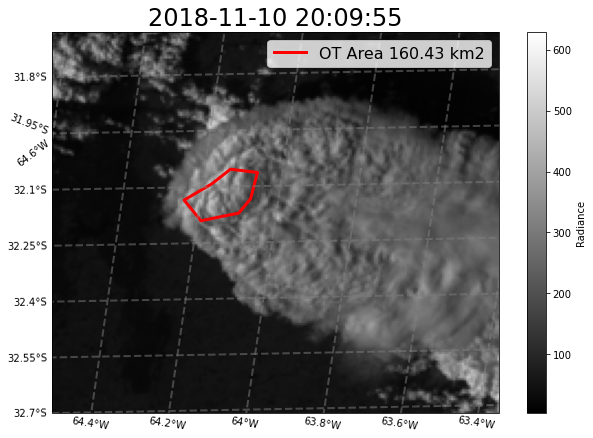

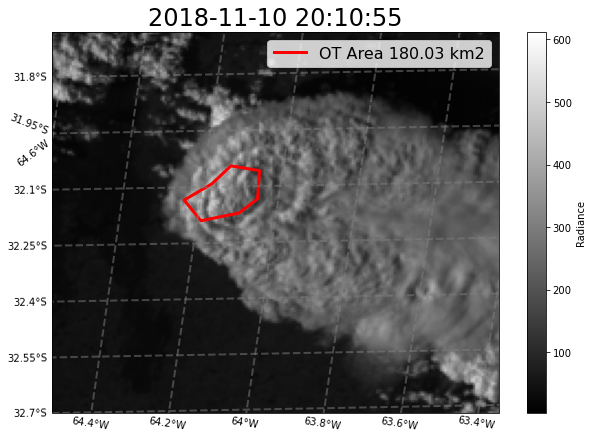

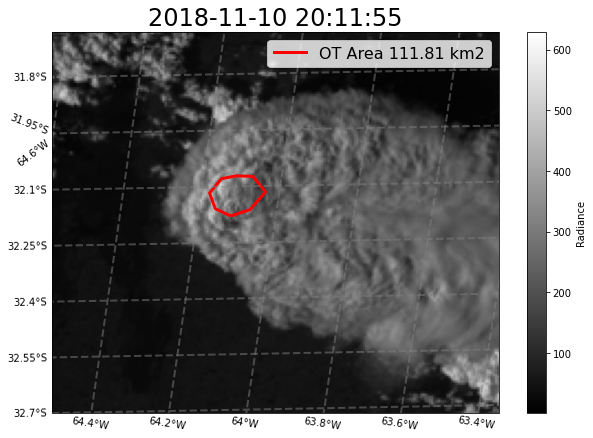

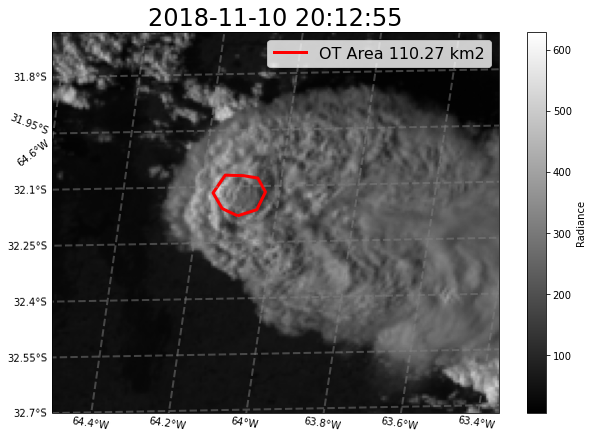

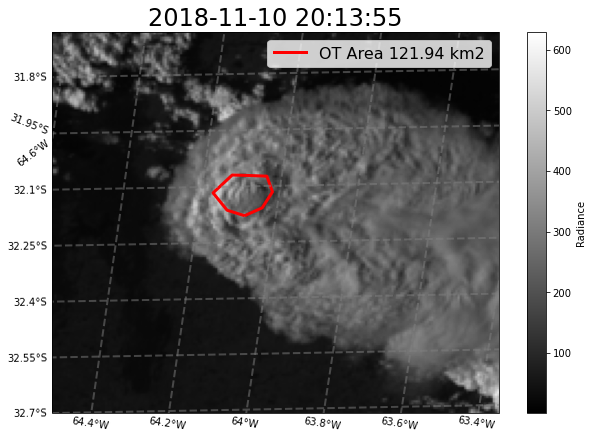

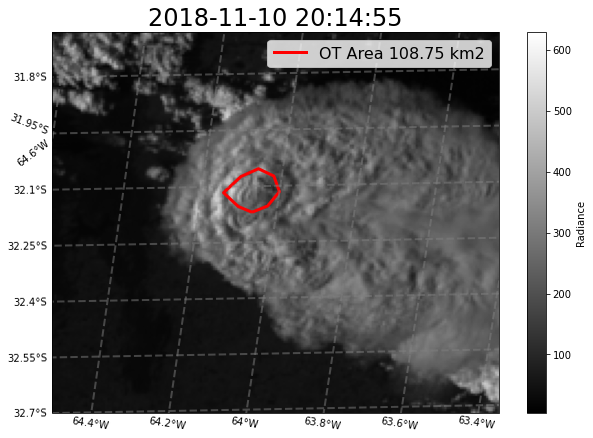

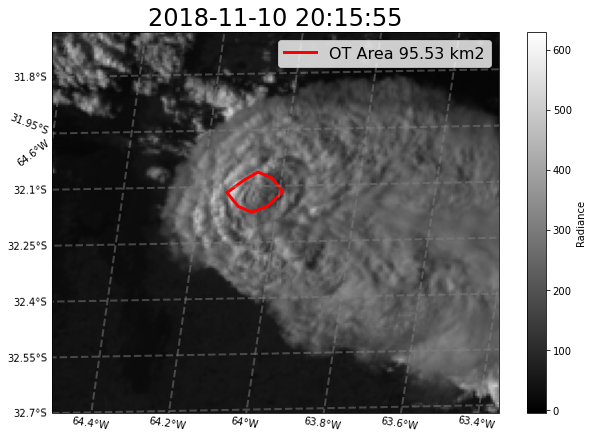

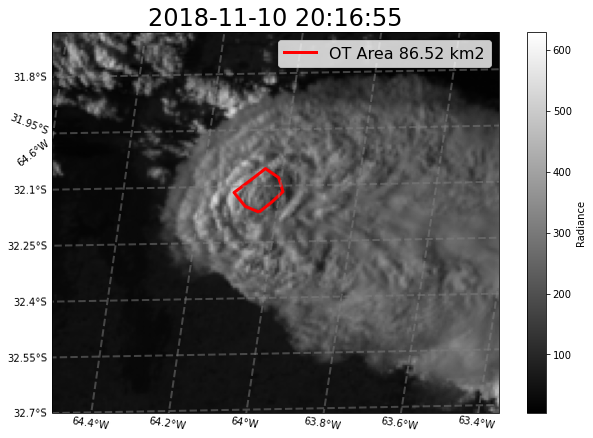

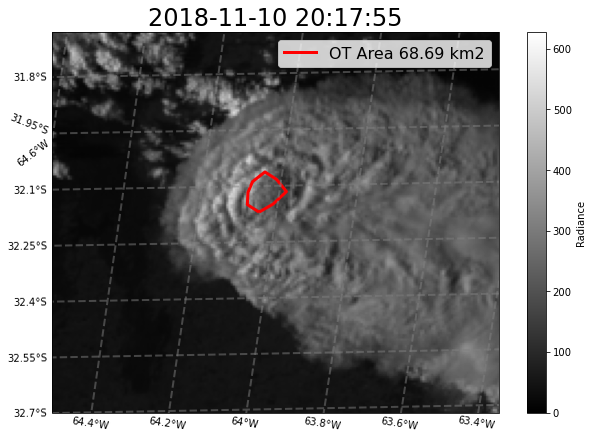

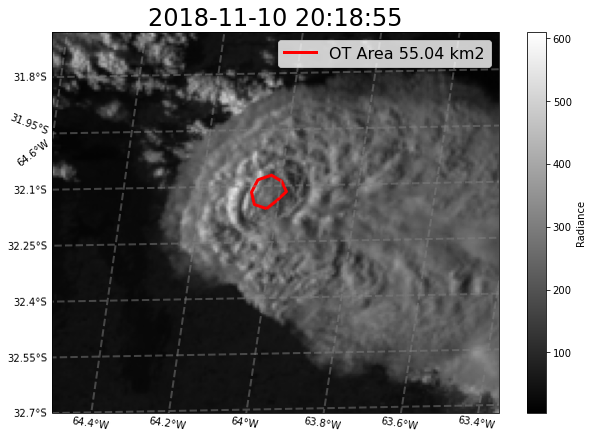

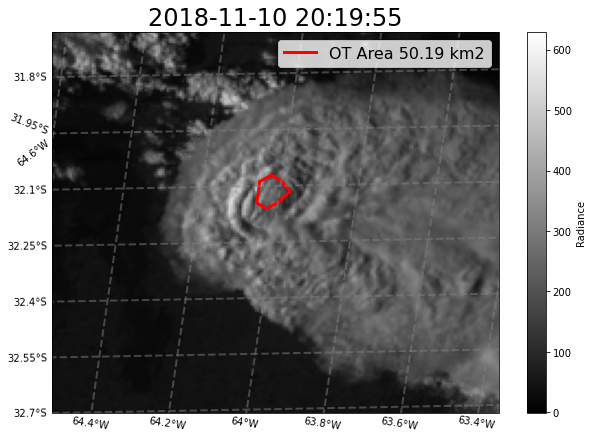

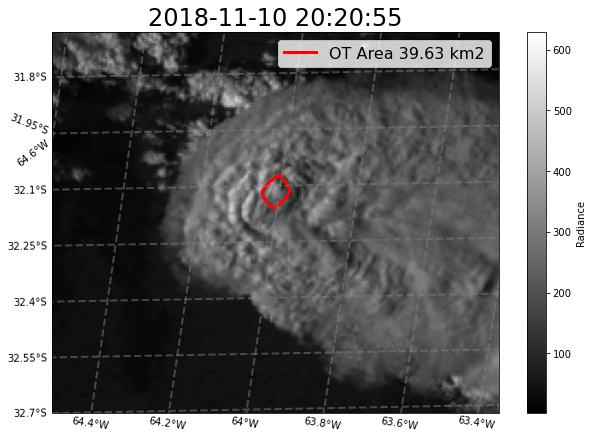

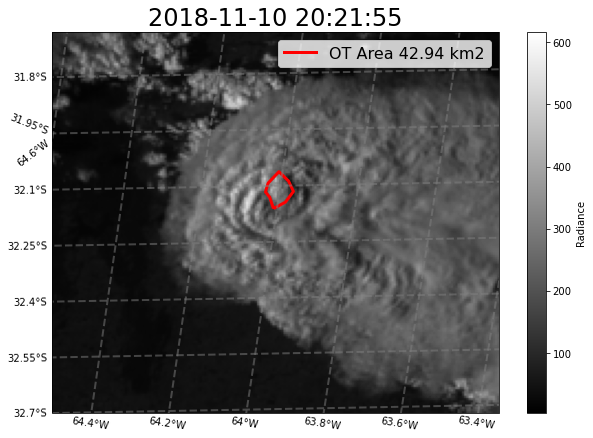

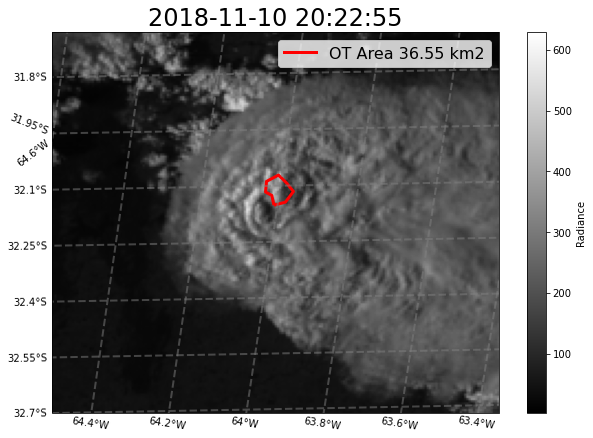

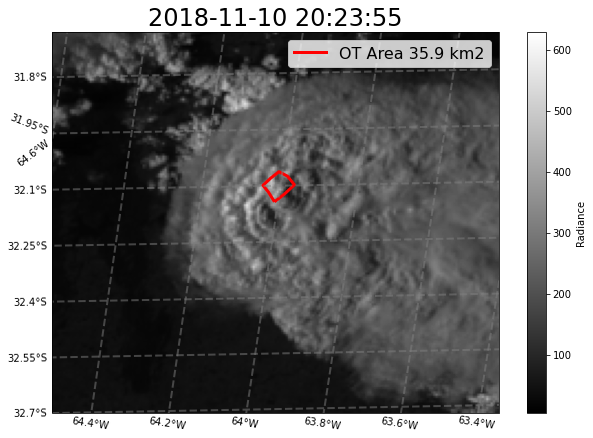

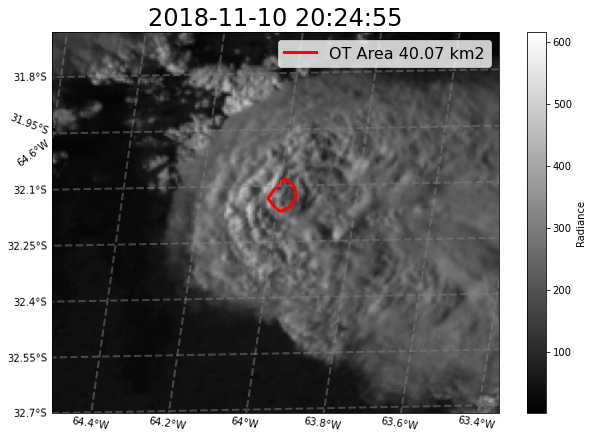

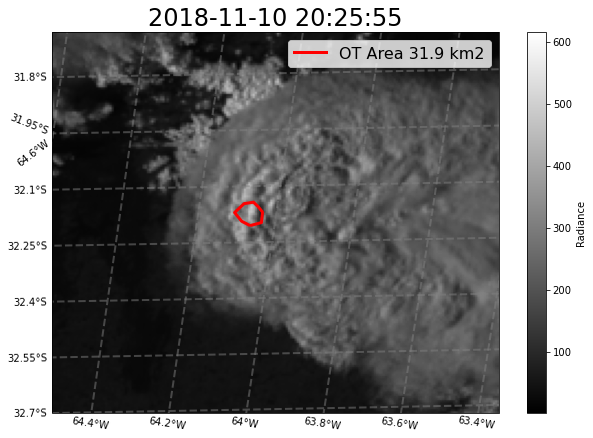

In [94]:
for file in sat_files[1:26]:
    plot_vis(file)

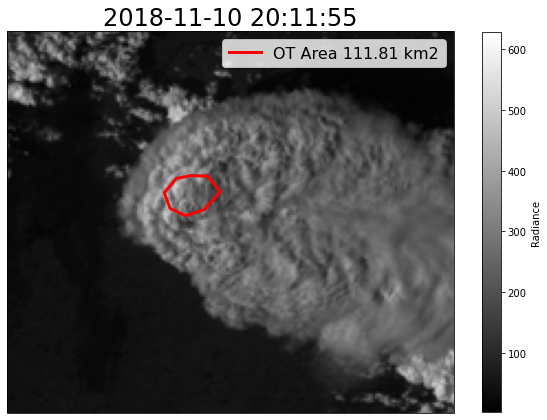

In [88]:
plot_vis(sat_files[11])

In [20]:
sat_files = sorted(glob.glob('/data/keeling/a/mgrover4/meso/relampago_sat_data/clipped_sat_data/*'))

In [10]:
dat = xr.open_dataset(sat_files[12]).metpy.parse_cf('Rad')

In [11]:
proj = dat.metpy.cartopy_crs
x = dat['x']
y = dat['y']

In [12]:


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline




In [64]:
sat_files[12][-18:-3]

'20181110_201255'

In [66]:
time = pd.to_datetime(sat_files[12][-18:-3], format='%Y%m%d_%H%M%S')

In [83]:
df['minute'] = df.index.minute

In [84]:
df[df.minute == time.minute]

index  area_circle_mean  area_circle_median  \
time                                                                         
2018-11-10 20:12:55.000000512      0        121.689502          130.434332   

                               area_circle_polygon  area_cold_pixels  \
time                                                                   
2018-11-10 20:12:55.000000512            110.26933               0.0   

                               e_radial  \
time                                      
2018-11-10 20:12:55.000000512       7.0   

                                                                   e_radial_del2  \
time                                                                               
2018-11-10 20:12:55.000000512  [0.13263702392578125, 0.209930419921875, 0.310...   

                                                                            e_tb  \
time                                                                               
2018-11-10 20:12:55.000000512  [195.72174072265625, 195.8573760986328, 196.25...   

                                                                        geometry  \
time                                                                               
2018-11-10 20:12:55.000000512  POLYGON ((-64.09821 -32.17857, -64.05131 -32.1...   

                                     lat  ...  \
time                                      ...   
2018-11-10 20:12:55.000000512 -32.116074  ...   

                                                                  sw_radial_del2  \
time                                                                               
2018-11-10 20:12:55.000000512  [0.09815216064453125, 0.14402389526367188, 0.1...   

                                                                           sw_tb  \
time                                                                               
2018-11-10 20:12:55.000000512  [195.72174072265625, 195.756591796875, 195.987...   

                                                       time tropopause_height  \
time                                                                            
2018-11-10 20:12:55.000000512 2018-11-10 20:12:55.000000512         16.622002   

                              tropopause_pressure  tropopause_temperature  \
time                                                                        
2018-11-10 20:12:55.000000512           97.639999              202.419998   

                              w_radial  \
time                                     
2018-11-10 20:12:55.000000512      8.0   

                                                                   w_radial_del2  \
time                                                                               
2018-11-10 20:12:55.000000512  [0.10791778564453125, 0.16202545166015625, 0.2...   

                                                                            w_tb  \
time                                                                               
2018-11-10 20:12:55.000000512  [195.72174072265625, 195.81478881835938, 196.1...   

                              minute  
time                                  
2018-11-10 20:12:55.000000512     12  

[1 rows x 40 columns]

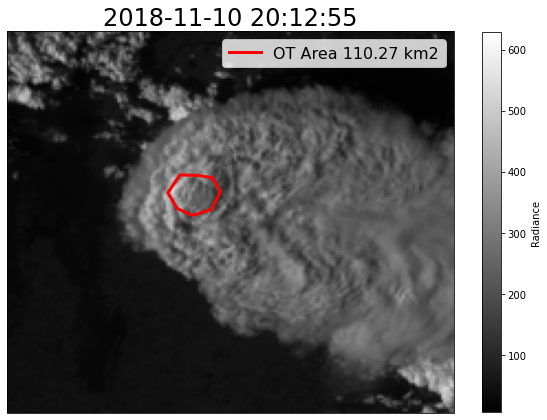

In [77]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=proj)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
ax.add_feature(cfeature.STATES.with_scale('50m'), linestyle=':', edgecolor='black')
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=2, edgecolor='black')

im = ax.imshow(dat, extent=(x.min(), x.max(), y.min(), y.max()), origin='upper', transform=proj, cmap='gist_gray')
plt.colorbar(im, shrink=.7, label='Radiance')

df_sub.plot(ax=ax, transform=ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=3)

plt.title(time, fontsize=24)

ax.plot(0, 0, color='red', lw=3, label=f'OT Area {np.round(df_sub.area_circle_polygon.values[0], 2)} km2')

ax.set_extent((-64.5, -63.5, -32.7, -31.7), crs=ccrs.PlateCarree())

plt.legend(loc='upper right', fontsize=16)

---

## 12 November 2018

In [28]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

import glob
datestr='20181112'
ihour='02'
files = sorted(glob.glob(f'/data/relamp/a/mgrover4/ot_data/{datestr}/*{ihour}????.cdf'))

In [29]:
files[34]

'/data/relamp/a/mgrover4/ot_data/20181112/cor1goecnvX1.a1.20181112.023454.cdf'

In [30]:
df

Empty GeoDataFrame
Columns: []
Index: []

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int

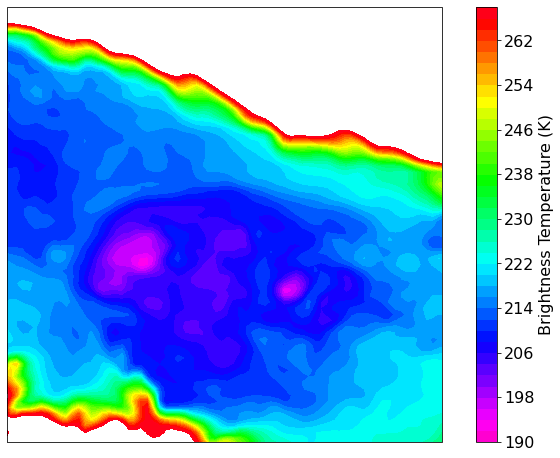

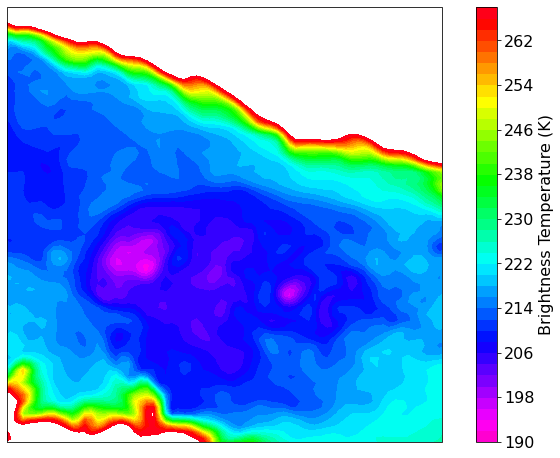

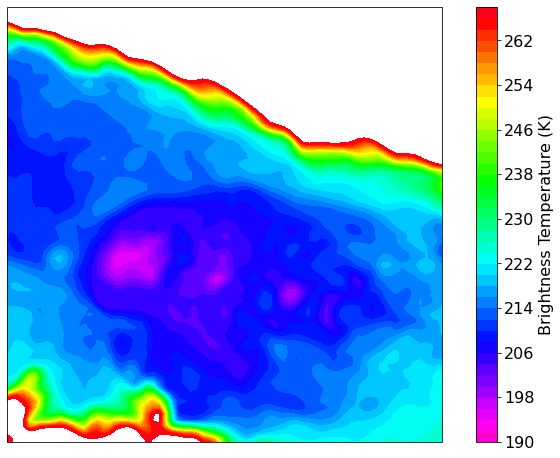

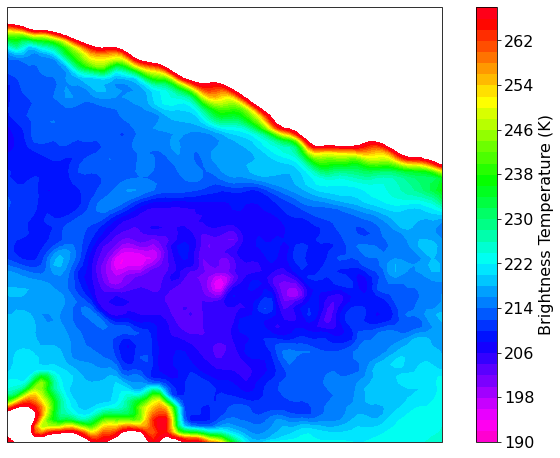

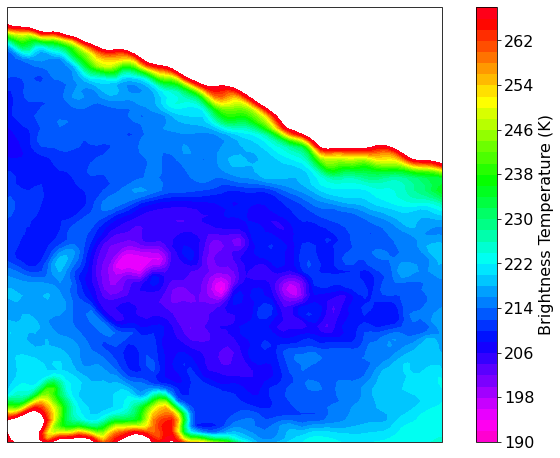

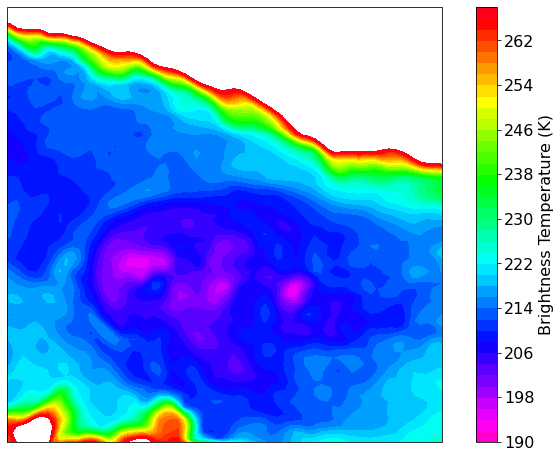

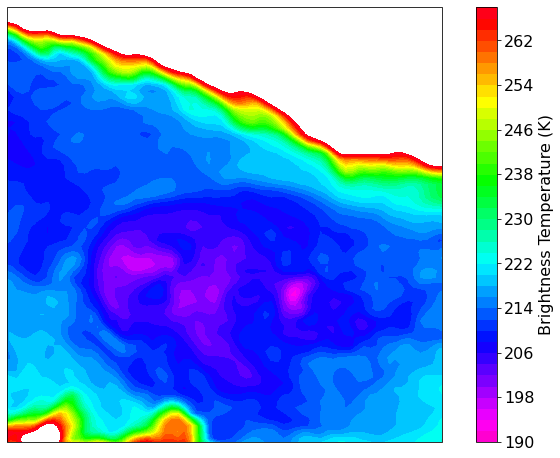

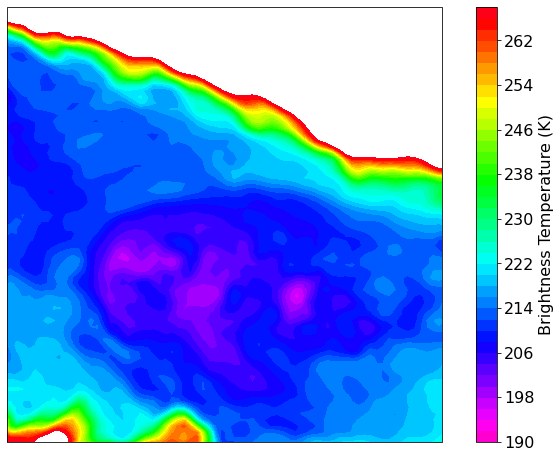

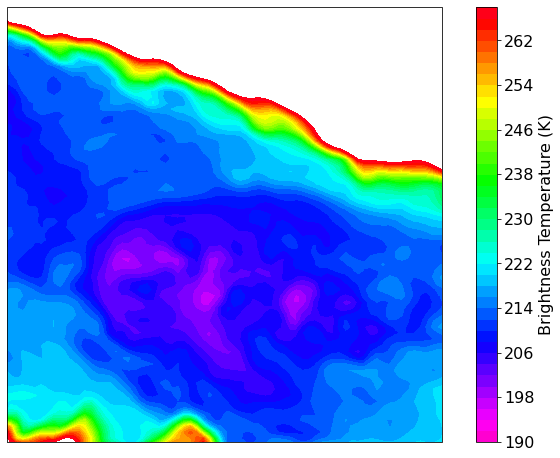

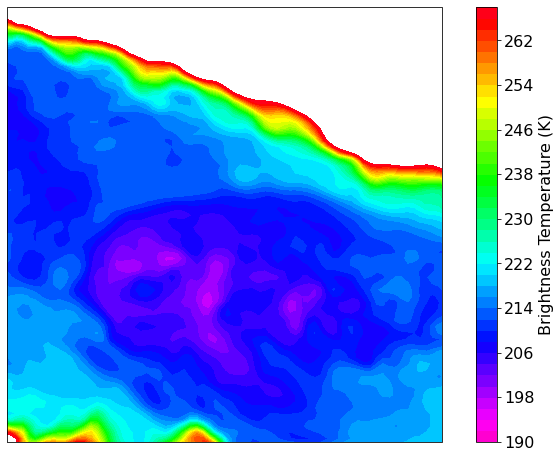

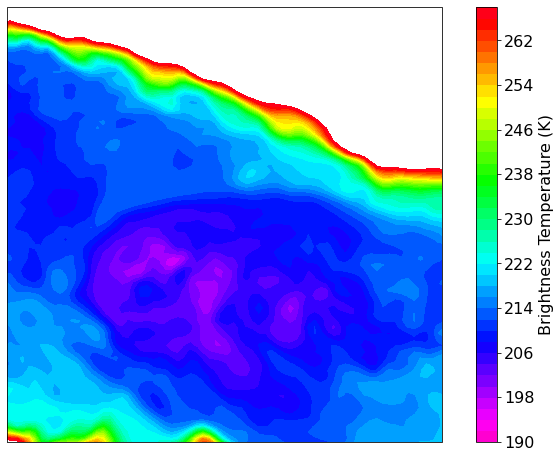

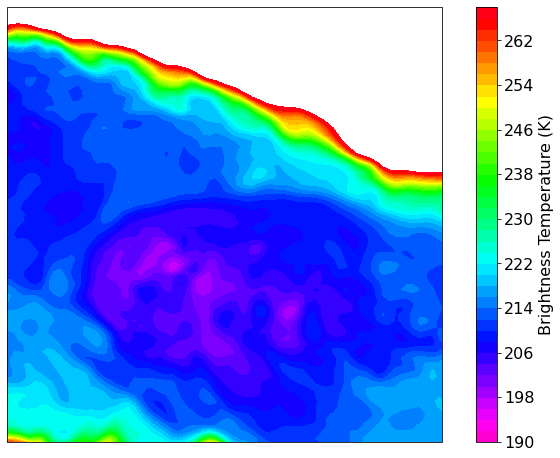

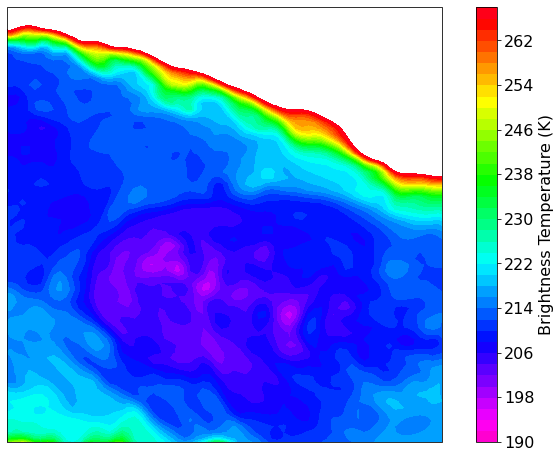

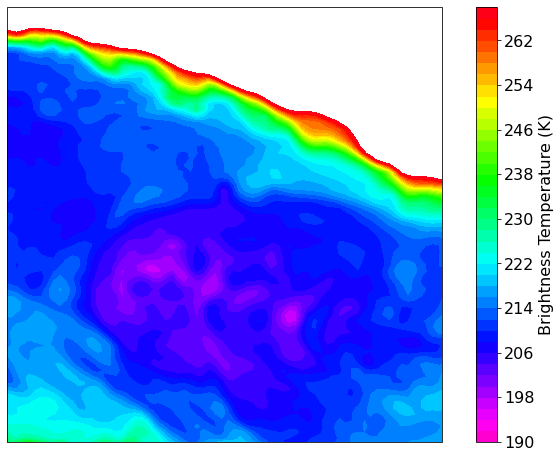

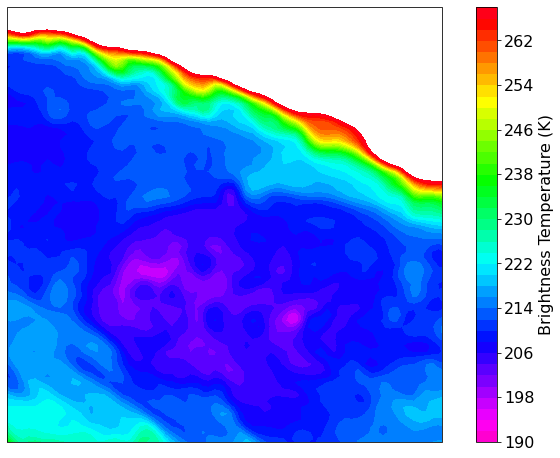

In [31]:
df_list = []
filtered_df_list = []

for file in files[30:45]:
    ds = xr.open_dataset(file).squeeze()
    df = process_ot_data(file, .5)
    
    ir_vals = ds.ir_brightness_temperature.values
    
    plt.figure(figsize=(12,8))
    
    lon = ds.longitude.values
    lat = ds.latitude.values

    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ax.set_extent((-64.5, -63.25, -31.75, -30.5))
    cf = plt.contourf(lon, lat, ir_vals, np.arange(190, 270, 2), cmap='gist_rainbow_r')
    cbar = plt.colorbar(cf)
    
    cbar.set_label('Brightness Temperature (K)', fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    
    try:
        df_ex = df[df.mintb == np.nanmin(df.mintb.values)]
        
    except:
        continue

    df_ex.plot(ax=ax, facecolor="none", edgecolor='black', lw=3,)

    ax.plot(0, 0, color='black', lw=3, label=f'OT Area {np.round(df_ex.area_polygon.values[0], 2)} km2 \n Prob: {np.round(df_ex.prob.values[0], 2)}')
    plt.legend(fontsize=16)

    #gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
    #                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    #try:
        #df_ex = df[df.mintb == np.nanmin(df.mintb.values)]
   #     df_ex = df[(df.lon > -64.5) & (df.lon < -64.2) & (df.lat > -32.1)]
    
        # If more than one OT, choose the one with the lowest min BT value
   #     df_ex = df_ex[df_ex.mintb == np.nanmin(df_ex.mintb.values)]

   #     df_ex.plot(ax=ax, facecolor="none", edgecolor='black', lw=3,)
   #     ax.plot(0, 0, color='black', lw=3, label=f'OT Area {np.round(df_ex.area_circle_polygon.values[0], 2)} km2 \n Prob: {np.round(df_ex.prob.values[0], 2)}')
   #     plt.legend(fontsize=16)
        
   #     filtered_df_list.append(df_ex)
        
    #except:
    #    None

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    gl.xlabel_style = {'size': 14, 'color': 'k'}
    gl.ylabel_style = {'size': 14, 'color': 'k'}

    plt.title(pd.to_datetime(df.time.values[0]).strftime('%d %b %y %H:%M:%S'), fontsize=24)
    plt.savefig(pd.to_datetime(df.time.values[0]).strftime('compare_plots/Nov12/%b_%d_%y_%H%M.%S.png'), dpi=300)
    plt.show()
    plt.close()
    
    #df_ex = df[df.mintb == np.nanmin(df.mintb.values)]
    #df_ex = df[(df.lon > -64) & (df.lon < -63.75)]
    
    # If more than one OT, choose the one with the lowest min BT value
    #df_ex = df_ex[df_ex.mintb == np.nanmin(df_ex.mintb.values)]

    #df_ex.plot(ax=ax, facecolor="none", edgecolor='black', lw=3,)
    
    df_list.append(df)

In [124]:
df = pd.concat(filtered_df_list[0:-2])

In [126]:
df.index = df.time

In [113]:
df = pd.read_csv('Revised_OTs_12_November_2018_0232_0243.csv', index_col='time', parse_dates=True)

FileNotFoundError: [Errno 2] No such file or directory: 'Revised_OTs_12_November_2018_0232_0243.csv'

In [140]:
df[df.prob > .7]

area_circle_mean  area_circle_median  \
time                                                        
2018-11-12 02:31:54         31.228643           29.648724   
2018-11-12 02:32:54         36.964643           42.867758   
2018-11-12 02:33:54         37.786199           36.914553   
2018-11-12 02:34:54         39.670733           36.908761   
2018-11-12 02:39:54         61.386926           64.241069   
2018-11-12 02:41:54         43.590309           49.262605   
2018-11-12 02:42:54         35.933292           32.135175   

                     area_circle_polygon  cloudtop_height  e_radial  \
time                                                                  
2018-11-12 02:31:54            28.222460        16.671001       4.0   
2018-11-12 02:32:54            34.215735        19.121000       5.0   
2018-11-12 02:33:54            33.992085        19.462002       3.0   
2018-11-12 02:34:54            35.987037        19.596001       3.0   
2018-11-12 02:39:54            55.949746        19.167002       4.0   
2018-11-12 02:41:54            39.091488        15.932001       4.0   
2018-11-12 02:42:54            32.424907        15.957001       5.0   

                                                         e_radial_del2  \
time                                                                     
2018-11-12 02:31:54  [0.15695953369140625, 0.2196807861328125, 0.23...   
2018-11-12 02:32:54  [0.20626068115234375, 0.3034820556640625, 0.35...   
2018-11-12 02:33:54  [0.20917510986328125, 0.24409866333007812, 0.1...   
2018-11-12 02:34:54  [0.29625701904296875, 0.37740325927734375, 0.2...   
2018-11-12 02:39:54  [0.186248779296875, 0.25388336181640625, 0.260...   
2018-11-12 02:41:54  [0.13306427001953125, 0.17688369750976562, 0.1...   
2018-11-12 02:42:54  [0.17418670654296875, 0.249053955078125, 0.281...   

                                                                  e_tb  \
time                                                                     
2018-11-12 02:31:54  [201.8682403564453, 202.02073669433594, 202.48...   
2018-11-12 02:32:54  [199.60467529296875, 199.59048461914062, 199.9...   
2018-11-12 02:33:54  [197.6213836669922, 198.6660919189453, 200.129...   
2018-11-12 02:34:54  [197.1431427001953, 198.1394500732422, 199.728...   
2018-11-12 02:39:54  [198.49203491210938, 199.05517578125, 199.9908...   
2018-11-12 02:41:54  [199.3667755126953, 199.35638427734375, 199.61...   
2018-11-12 02:42:54  [199.37437438964844, 199.26097106933594, 199.4...   

                                                              geometry  \
time                                                                     
2018-11-12 02:31:54  POLYGON ((-63.90179 -31.30357, -63.87833 -31.2...   
2018-11-12 02:32:54  POLYGON ((-63.90179 -31.31250, -63.87364 -31.3...   
2018-11-12 02:33:54  POLYGON ((-63.88393 -31.33036, -63.86517 -31.3...   
2018-11-12 02:34:54  POLYGON ((-63.88393 -31.33929, -63.86517 -31.3...   
2018-11-12 02:39:54  POLYGON ((-63.91964 -31.37500, -63.89619 -31.3...   
2018-11-12 02:41:54  POLYGON ((-63.93750 -31.33036, -63.90936 -31.3...   
2018-11-12 02:42:54  POLYGON ((-63.93750 -31.33929, -63.91405 -31.3...   

                            lat   lat_corr  ... sw_radial  \
time                                        ...             
2018-11-12 02:31:54  -31.258928 -33.082355  ...       4.0   
2018-11-12 02:32:54  -31.276785 -31.146786  ...       6.0   
2018-11-12 02:33:54  -31.294643 -31.162643  ...       5.0   
2018-11-12 02:34:54    -31.3125 -31.179501  ...       5.0   
2018-11-12 02:39:54  -31.348215 -31.217215  ...       7.0   
2018-11-12 02:41:54  -31.294643 -31.186644  ...       6.0   
2018-11-12 02:42:54    -31.3125 -31.204500  ...       4.0   

                                                        sw_radial_del2  \
time                                                                     
2018-11-12 02:31:54  [0.0468292236328125, 0.0654754638671875, 0.076...   
2018-11-12 02:32:54  [0.08431243896484375, 0.1186752319335

Text(0.5, 1.0, '12 November 2018 Multicellular OTA')

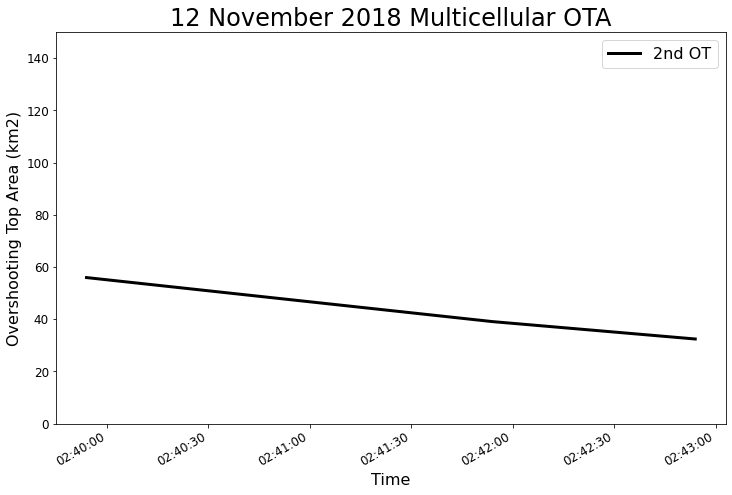

In [148]:
plt.figure(figsize=(12,8))
#df[df.prob > .7].area_circle_polygon[:4].plot(linewidth=3, color='red', label='1st OT')
df[df.prob > .7].area_circle_polygon[4:].plot(linewidth=3, color='black', label='2nd OT')
plt.ylim(0,150)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

ax.xaxis.set_minor_locator(AutoMinorLocator())

plt.ylabel('Overshooting Top Area (km2)', fontsize=16)
plt.xlabel('Time', fontsize=16)

plt.legend(fontsize=16)

plt.title('12 November 2018 Multicellular OTA', fontsize=24)

In [156]:
df.to_csv('Revised_OTs_12_November_2018_0232_0243.csv')

In [157]:
trop_temp = df.tropopause_temperature.values.mean()

In [158]:
df.tropopause_temperature

time
2018-11-12 02:31:54.000000000    201.190002
2018-11-12 02:32:54.000000000    195.970001
2018-11-12 02:33:54.000000000    195.979996
2018-11-12 02:34:54.000000000    196.000000
2018-11-12 02:37:54.000000000    195.949997
2018-11-12 02:38:54.000000000    195.919998
2018-11-12 02:39:54.000000000    195.940002
2018-11-12 02:40:54.000001024    195.899994
2018-11-12 02:41:54.000000000    195.750000
2018-11-12 02:42:54.000000000    195.759995
Name: tropopause_temperature, dtype: float64

Text(0.5, 1.0, '12 November 2018 Multicellular \n OT Minimum Brightness Temperature')

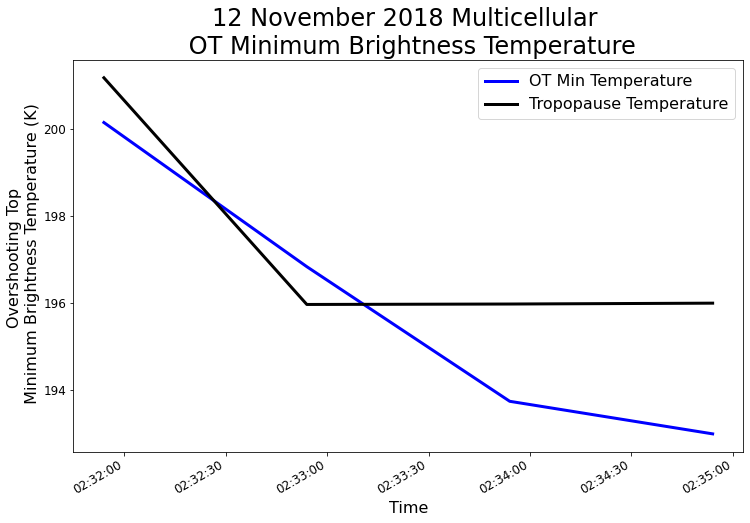

In [155]:
plt.figure(figsize=(12,8))
#df.mintb.plot(linewidth=3, color='blue', label='Minimum Brightness Temperature')
df[df.prob > .7].mintb[:4].plot(linewidth=3, color='blue', label='OT Min Temperature')
df[df.prob > .7][:4].tropopause_temperature.plot(linewidth=3, color='black', label='Tropopause Temperature')
#df[df.prob > .7].mintb[4:].plot(linewidth=3, color='purple', label='OT Min Temperature')
#df[df.prob > .7][4:].tropopause_temperature.plot(linewidth=3, color='black', label='Tropopause Temperature')
#plt.ylim(0,150)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

ax.xaxis.set_minor_locator(AutoMinorLocator())

#plt.axhline(trop_temp, label=f'Tropopause Temperature: {np.round(trop_temp,2)} K', linewidth=3, color='black', linestyle='--')

plt.ylabel('Overshooting Top \n Minimum Brightness Temperature (K)', fontsize=16)
plt.xlabel('Time', fontsize=16)

plt.legend(fontsize=16)

plt.title('12 November 2018 Multicellular \n OT Minimum Brightness Temperature', fontsize=24)

Text(0.5, 1.0, '10 November 2018 Supercell \n OT Cloud Top Height')

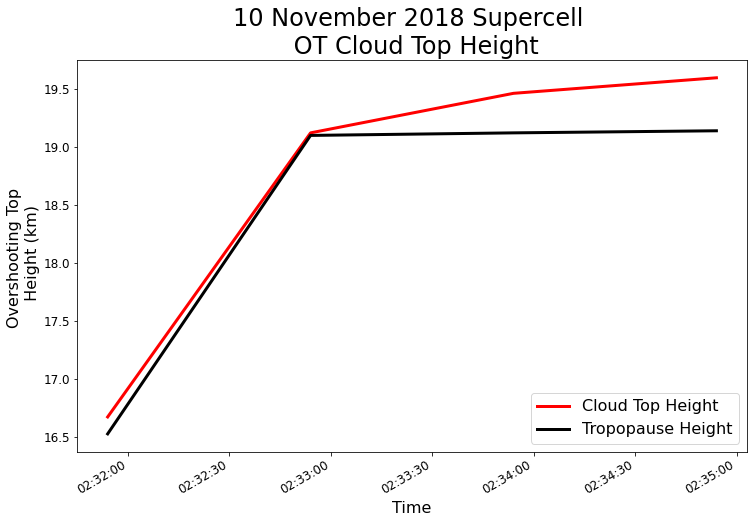

In [145]:
plt.figure(figsize=(12,8))
df[df.prob > .7][0:4].cloudtop_height.plot(linewidth=3, color='red', label='Cloud Top Height')
df[df.prob > .7][0:4].tropopause_height.plot(linewidth=3, color='black', label='Tropopause Height')
#plt.ylim(0,150)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

ax.xaxis.set_minor_locator(AutoMinorLocator())
#plt.axhline(trop_height, label=f'Tropopause Height: {np.round(trop_height,2)} km', linewidth=3, color='black', linestyle='--')

plt.ylabel('Overshooting Top \n Height (km)', fontsize=16)
plt.xlabel('Time', fontsize=16)

plt.legend(loc='lower right', fontsize=16)

plt.title('10 November 2018 Supercell \n OT Cloud Top Height', fontsize=24)

---
## 14 December 2018 Case

In [15]:
llcrnr=[-33.206342, -65.906586]
urcrnr=[-30.255825, -62.630553]

import glob
datestr='20181214'
ihour='02'
files = sorted(glob.glob(f'/data/relamp/a/mgrover4/ot_data/{datestr}/*{ihour}????.cdf'))

(array([ 95,  95,  95,  95,  95,  95,  96,  96,  96,  96,  96,  96,  96,
        97,  97,  97,  97,  97,  97,  97,  98,  98,  98,  98,  98,  99,
        99,  99,  99,  99, 100, 100, 101, 101, 102]), array([18, 19, 20, 22, 23, 24, 18, 19, 20, 21, 22, 23, 24, 17, 18, 19, 20,
       21, 22, 23, 17, 18, 19, 20, 21, 17, 18, 19, 20, 21, 19, 20, 19, 20,
       20]))
[0.081787109375, 0.1028900146484375, 0.09815597534179688, 0.06499481201171875, 0.060474395751953125, 0.0714111328125, 0.08216094970703125, 0.07988357543945312, 0.0655059814453125, 0.042987823486328125, 0.014591217041015625, -0.01804351806640625, -0.05403900146484375, -0.09161376953125, -0.1246490478515625, -0.14701461791992188, -0.15686798095703125, -0.15414047241210938, -0.141571044921875, -0.121826171875, -0.09452056884765625, -0.059112548828125, -0.017398834228515625, 0.026706695556640625, 0.06311416625976562, 0.08172225952148438, 0.07856369018554688, 0.05452728271484375, 0.0238494873046875, 0.00250244140625, 4.1961669921875e-0

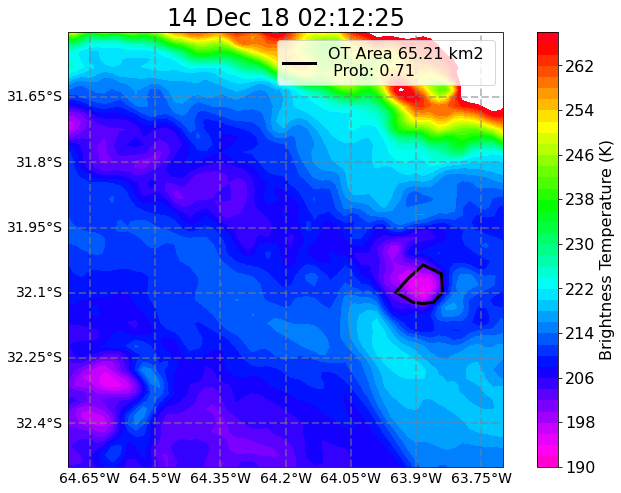

(array([80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 82, 82, 82,
       83, 83, 83, 83, 83, 83, 84, 84, 84]), array([68, 69, 70, 71, 67, 68, 69, 70, 71, 72, 66, 67, 68, 69, 70, 71, 72,
       67, 68, 69, 70, 71, 72, 68, 69, 70]))
[0.37665557861328125, 0.5258407592773438, 0.5567703247070312, 0.2766304016113281, -0.025524139404296875, -0.263214111328125, -0.3954582214355469, -0.4058990478515625, -0.331146240234375, -0.21926498413085938, -0.11124038696289062, -0.038433074951171875, -0.000881195068359375, 0.010814666748046875, 0.01261138916015625, 0.018108367919921875, 0.02487945556640625, 0.0263824462890625, 0.01561737060546875, -0.011173248291015625, -0.044269561767578125, -0.07176589965820312, -0.0865631103515625, -0.08591079711914062, -0.07961273193359375, -0.07727813720703125, -0.07518386840820312, -0.06707382202148438, -0.0498199462890625, -0.022960662841796875, 0.006351470947265625, 0.030826568603515625, 0.05023956298828125, 0.06493759155273438, 0.0704498291015625, 0.0620

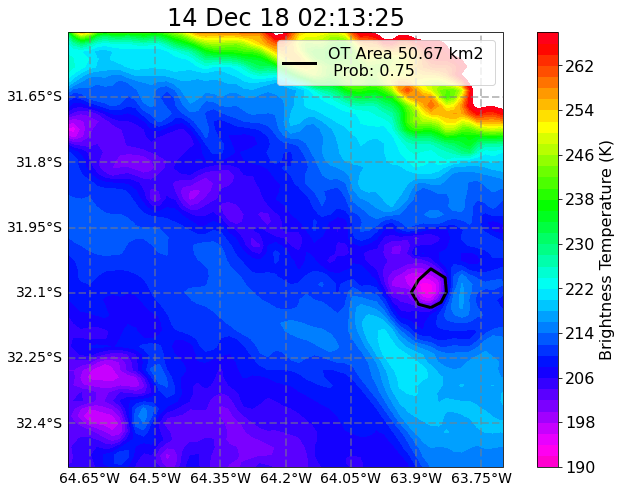

(array([80, 81, 81, 81, 81, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 84, 84,
       84, 84, 84]), array([70, 68, 69, 70, 71, 67, 68, 69, 70, 68, 69, 70, 71, 72, 73, 68, 69,
       70, 71, 72]))
[0.25804901123046875, 0.3429603576660156, 0.3110771179199219, 0.051761627197265625, -0.1904754638671875, -0.3315544128417969, -0.36231231689453125, -0.3009185791015625, -0.19992828369140625, -0.11118316650390625, -0.04923248291015625, -0.01551055908203125, 0.00374603271484375, 0.02176666259765625, 0.034328460693359375, 0.0332489013671875, 0.011989593505859375, -0.03134918212890625, -0.0816497802734375, -0.12110519409179688, -0.1382904052734375, -0.12794113159179688, -0.1030426025390625, -0.07845306396484375, -0.0581817626953125, -0.042079925537109375, -0.024242401123046875, 0.000720977783203125, 0.030315399169921875, 0.05937957763671875, 0.07993316650390625, 0.08484649658203125, 0.07330703735351562, 0.047191619873046875, 0.01282501220703125, -0.02243804931640625, -0.051578521728515625, -0.0685653

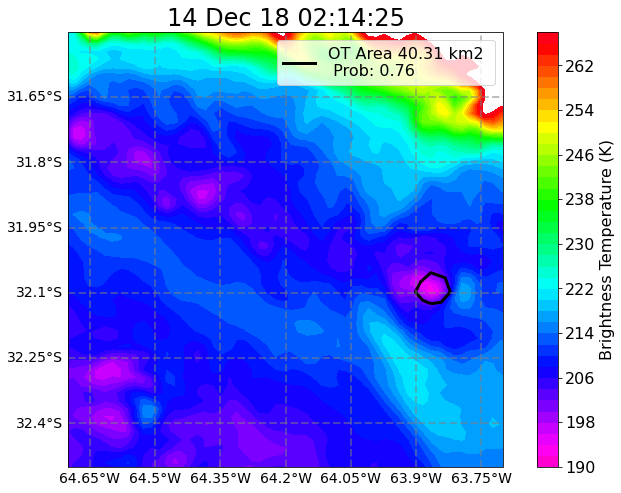

(array([89, 89, 89, 89, 90, 90, 90, 90, 91, 91, 91, 91, 92, 92]), array([84, 85, 86, 87, 84, 85, 86, 87, 84, 85, 86, 87, 85, 86]))
[0.22379302978515625, 0.29000091552734375, 0.25463104248046875, 0.045146942138671875, -0.14109039306640625, -0.2590370178222656, -0.2989311218261719, -0.266357421875, -0.19295883178710938, -0.11339950561523438, -0.048343658447265625, -0.010707855224609375, 0.00351715087890625, 0.0029144287109375, -0.002567291259765625, -0.004497528076171875, -0.001850128173828125, 0.003192901611328125, 0.003002166748046875, -0.009578704833984375, -0.034336090087890625, -0.06745147705078125, -0.09799957275390625, -0.11513900756835938, -0.11551666259765625, -0.09937667846679688, -0.07392120361328125, -0.047389984130859375, -0.025188446044921875, -0.011264801025390625, -0.006587982177734375, -0.010833740234375, -0.021484375, -0.03441619873046875, -0.041210174560546875, -0.033588409423828125, -0.00820159912109375, 0.03369903564453125, 0.07738494873046875, 0.07595062255859375, 0

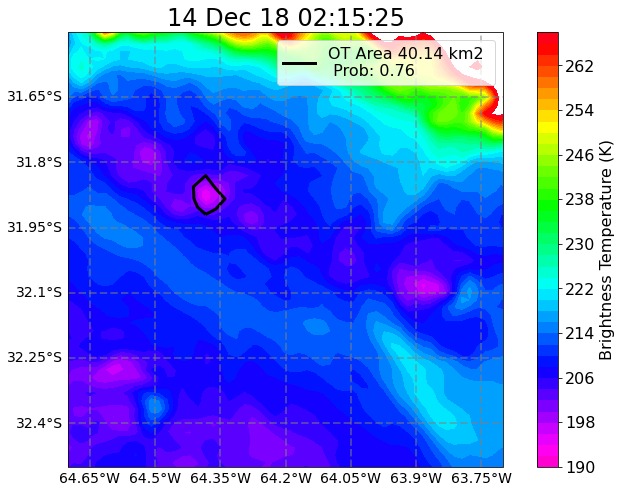

(array([89, 89, 89, 89, 89, 90, 90, 90, 90, 90, 91, 91, 91, 91, 91, 92, 92,
       92, 92, 92, 92, 93, 93, 93, 93]), array([84, 85, 86, 87, 88, 84, 85, 86, 87, 88, 84, 85, 86, 87, 88, 82, 83,
       84, 85, 86, 87, 83, 84, 85, 86]))
[0.287841796875, 0.4128990173339844, 0.47080230712890625, 0.30010986328125, 0.087677001953125, -0.12046432495117188, -0.28029632568359375, -0.3568878173828125, -0.3496818542480469, -0.2722129821777344, -0.1600494384765625, -0.050930023193359375, 0.030811309814453125, 0.07001495361328125, 0.07482528686523438, 0.0589141845703125, 0.034755706787109375, 0.011661529541015625, -0.0124664306640625, -0.0413665771484375, -0.0739593505859375, -0.1069183349609375, -0.132843017578125, -0.1443328857421875, -0.13803863525390625, -0.11368179321289062, -0.07915115356445312, -0.044384002685546875, -0.01930999755859375, -0.010768890380859375, -0.013317108154296875, -0.018779754638671875, -0.02033233642578125, -0.0129547119140625, 0.002532958984375, 0.023326873779296875, 0.04

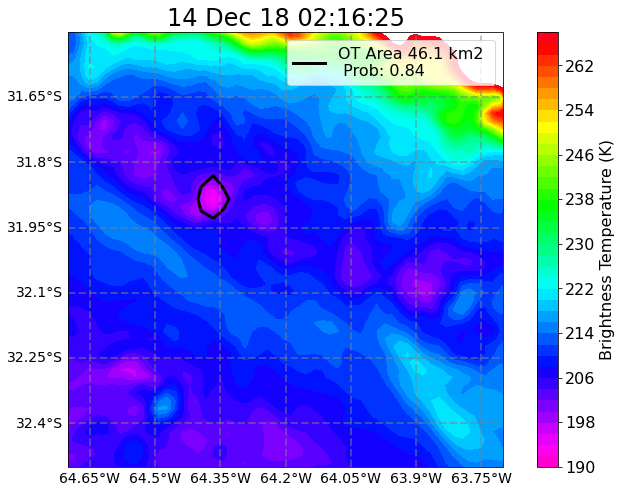

(array([88, 89, 89, 89, 90, 90, 90, 90, 91, 91, 91, 91, 91, 91, 92, 92, 92,
       92, 92, 92, 93, 93, 93, 93, 93, 93, 94, 94, 94, 94]), array([86, 85, 86, 87, 85, 86, 87, 88, 83, 84, 85, 86, 87, 88, 83, 84, 85,
       86, 87, 88, 83, 84, 85, 86, 87, 88, 84, 85, 86, 87]))
[0.2456817626953125, 0.34432220458984375, 0.3675689697265625, 0.18415451049804688, -0.033100128173828125, -0.23601913452148438, -0.37220001220703125, -0.40090179443359375, -0.33225250244140625, -0.19551849365234375, -0.0456390380859375, 0.06523895263671875, 0.12173843383789062, 0.12319564819335938, 0.091156005859375, 0.0489044189453125, 0.004398345947265625, -0.039211273193359375, -0.08273696899414062, -0.12570571899414062, -0.15843582153320312, -0.17081451416015625, -0.16027069091796875, -0.12860107421875, -0.08749771118164062, -0.049892425537109375, -0.023761749267578125, -0.0132293701171875, -0.012012481689453125, -0.011871337890625, -0.007171630859375, 0.005443572998046875, 0.022918701171875, 0.04035186767578125, 

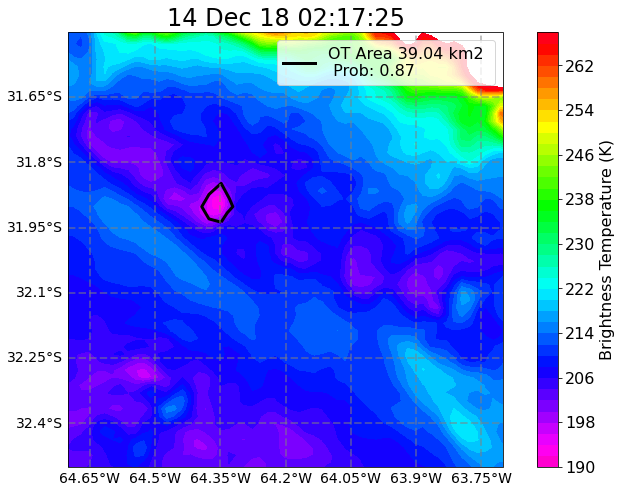

(array([83, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 85, 86, 86, 86, 86,
       86, 86, 86, 87, 87, 87, 87, 87, 87]), array([71, 71, 72, 73, 74, 75, 72, 73, 74, 75, 76, 77, 78, 72, 73, 74, 75,
       76, 77, 78, 73, 74, 75, 76, 77, 78]))
[0.30980682373046875, 0.4169883728027344, 0.40856170654296875, 0.16205596923828125, -0.05522918701171875, -0.17403793334960938, -0.20690536499023438, -0.1887969970703125, -0.16257858276367188, -0.1637115478515625, -0.19015121459960938, -0.22784805297851562, -0.2521705627441406, -0.2416534423828125, -0.1981201171875, -0.13259124755859375, -0.06967926025390625, -0.031436920166015625, -0.015960693359375, -0.014270782470703125, -0.0131072998046875, -0.0017547607421875, 0.016040802001953125, 0.03363800048828125, 0.04730224609375, 0.053073883056640625, 0.0431365966796875, 0.012165069580078125, -0.031368255615234375, -0.074066162109375, -0.09651947021484375, -0.08393096923828125, -0.046039581298828125, 0.001224517822265625, 0.041728973388671875, 0.06314086

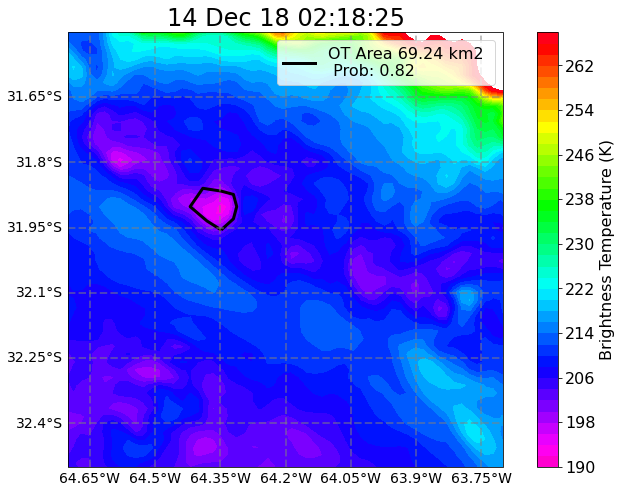

(array([83, 83, 83, 84, 84, 84, 84, 84, 84, 84, 85, 85, 85, 85, 85, 85, 86,
       86, 86, 86, 86, 86, 86, 87, 87, 87, 87, 87, 87, 87, 88, 88, 88, 88,
       88, 88]), array([74, 75, 76, 72, 73, 74, 75, 76, 77, 78, 73, 74, 75, 76, 77, 78, 73,
       74, 75, 76, 77, 78, 79, 73, 74, 75, 76, 77, 78, 79, 74, 75, 76, 77,
       78, 79]))
[0.27950286865234375, 0.3533058166503906, 0.2876548767089844, 0.010295867919921875, -0.212493896484375, -0.32396697998046875, -0.34917449951171875, -0.3317375183105469, -0.3078346252441406, -0.3012657165527344, -0.2937049865722656, -0.26198577880859375, -0.20569992065429688, -0.1335296630859375, -0.06781387329101562, -0.02834320068359375, -0.01102447509765625, -0.005580902099609375, -0.0008392333984375, 0.010997772216796875, 0.023281097412109375, 0.027759552001953125, 0.024211883544921875, 0.014125823974609375, -0.0022430419921875, -0.024261474609375, -0.04846954345703125, -0.06951522827148438, -0.07738113403320312, -0.06402206420898438, -0.0339126586914062

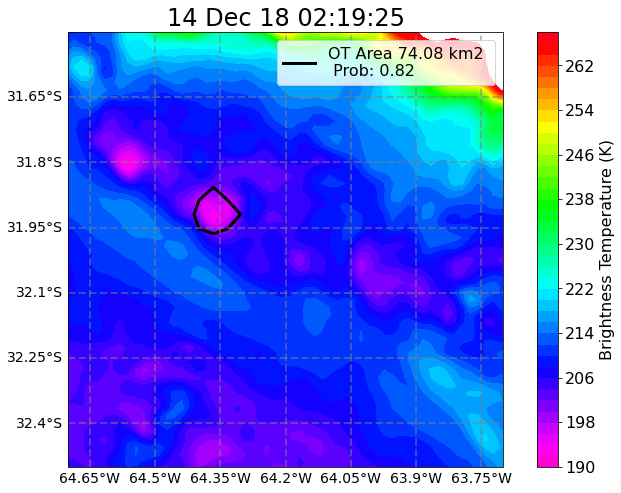

(array([71, 72, 72, 72, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 75,
       75, 75, 75, 75, 75, 76, 76, 76, 76]), array([53, 53, 54, 55, 52, 53, 54, 55, 56, 57, 52, 53, 54, 55, 56, 57, 52,
       53, 54, 55, 56, 57, 53, 54, 55, 56]))
[0.36865997314453125, 0.5174980163574219, 0.5917549133300781, 0.43996429443359375, 0.2939414978027344, 0.15878677368164062, -0.00608062744140625, -0.22772979736328125, -0.4335670471191406, -0.5419654846191406, -0.5347862243652344, -0.4228782653808594, -0.26959991455078125, -0.13811111450195312, -0.03827667236328125, 0.032382965087890625, 0.07239151000976562, 0.08025741577148438, 0.058406829833984375, 0.01352691650390625, -0.0345306396484375, -0.06571578979492188, -0.0723419189453125, -0.053470611572265625, -0.0227813720703125, 0.00421142578125, 0.019268035888671875, 0.01930999755859375, 0.01459503173828125, 0.015750885009765625, 0.021549224853515625, 0.025753021240234375, 0.013866424560546875, -0.023555755615234375, -0.06738662719726562, -0.09420013

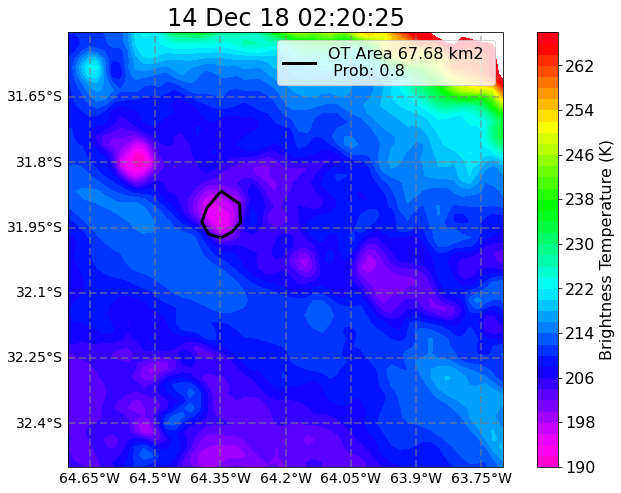

(array([72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74,
       75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 77, 77, 77, 77]), array([54, 55, 56, 52, 53, 54, 55, 56, 57, 58, 52, 53, 54, 55, 56, 57, 58,
       52, 53, 54, 55, 56, 57, 58, 53, 54, 55, 56, 57, 54, 55, 56, 57]))
[0.333251953125, 0.4346199035644531, 0.39325714111328125, 0.09764480590820312, -0.18563461303710938, -0.4126319885253906, -0.5593910217285156, -0.6112098693847656, -0.5704231262207031, -0.4499320983886719, -0.2878875732421875, -0.1264190673828125, 0.001739501953125, 0.07220458984375, 0.08458328247070312, 0.0491943359375, -0.004810333251953125, -0.047252655029296875, -0.06275558471679688, -0.045795440673828125, -0.015422821044921875, 0.006404876708984375, 0.0107269287109375, -0.004184722900390625, -0.02417755126953125, -0.03386688232421875, -0.02877044677734375, -0.010196685791015625, 0.00830078125, 0.013042449951171875, 0.002056121826171875, -0.021251678466796875, -0.043674468994140625, -0.0517

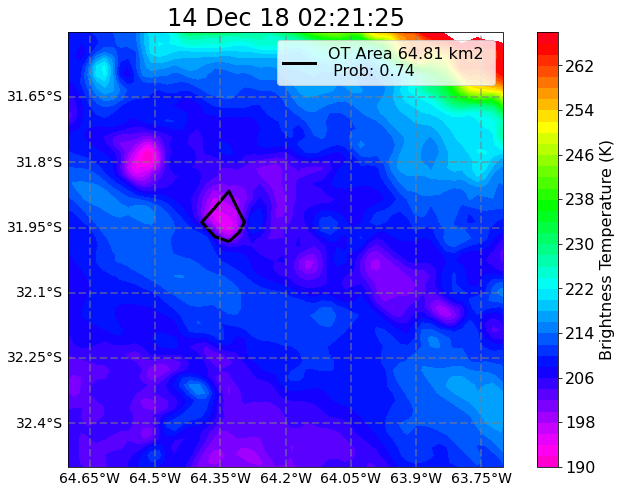

(array([83, 84, 84, 84, 84, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 87, 87,
       87, 87, 88, 88, 88, 89]), array([79, 77, 78, 79, 80, 76, 77, 78, 79, 80, 76, 77, 78, 79, 80, 76, 77,
       78, 79, 76, 77, 78, 78]))
[0.240875244140625, 0.3365631103515625, 0.3580780029296875, 0.18432998657226562, 0.00626373291015625, -0.113922119140625, -0.14415740966796875, -0.07228469848632812, 0.06430816650390625, 0.21004867553710938, 0.2862434387207031, 0.23027801513671875, 0.0668792724609375, -0.14898681640625, -0.3287315368652344, -0.3962860107421875, -0.359222412109375, -0.2507591247558594, -0.1230621337890625, -0.0243072509765625, 0.03218841552734375, 0.046710968017578125, 0.03919219970703125, 0.0303955078125, 0.024738311767578125, 0.02010345458984375, 0.004505157470703125, -0.03151702880859375, -0.077392578125, -0.117767333984375, -0.13816070556640625, -0.12888717651367188, -0.09862136840820312, -0.059906005859375, -0.02239227294921875, 0.006229400634765625, 0.023284912109375, 0.02840805053710

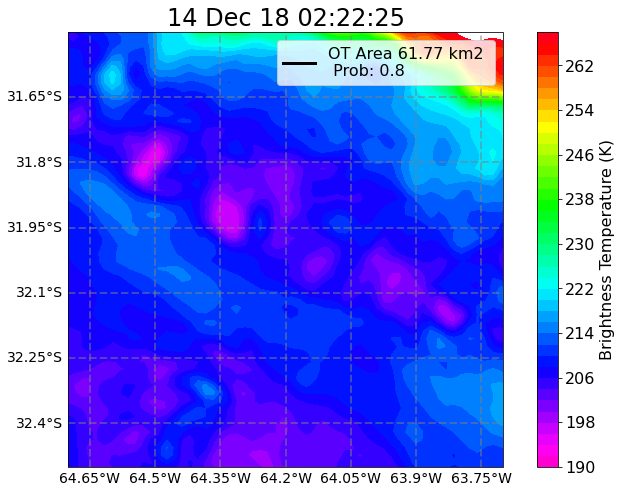

(array([75, 76, 76, 76, 77, 77, 77, 77, 78, 78, 78, 78, 78, 79, 79, 79, 79,
       79, 80, 80, 80]), array([62, 61, 62, 63, 60, 61, 62, 63, 59, 60, 61, 62, 63, 59, 60, 61, 62,
       63, 61, 62, 63]))
[0.152587890625, 0.20868301391601562, 0.22588729858398438, 0.155364990234375, 0.11930084228515625, 0.13806915283203125, 0.19392776489257812, 0.2573051452636719, 0.2894706726074219, 0.25801849365234375, 0.1648712158203125, 0.027111053466796875, -0.11179351806640625, -0.20897674560546875, -0.2503166198730469, -0.23572921752929688, -0.19262313842773438, -0.15122604370117188, -0.1256103515625, -0.1214141845703125, -0.1265869140625, -0.12654495239257812, -0.11422348022460938, -0.0865325927734375, -0.04888153076171875, -0.008693695068359375, 0.0270843505859375, 0.051883697509765625, 0.0601654052734375, 0.0482177734375, 0.018646240234375, -0.022113800048828125, -0.058650970458984375, -0.07582473754882812, -0.06852340698242188, -0.03792572021484375, -0.000377655029296875, 0.02658843994140625, 0.0

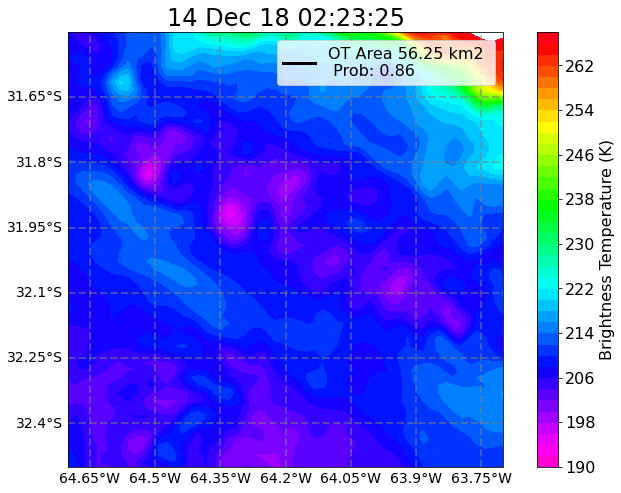

(array([75, 76, 76, 77, 77, 78, 78, 78, 78, 79, 79, 79, 79, 79, 80, 80, 80]), array([63, 62, 63, 62, 63, 61, 62, 63, 64, 60, 61, 62, 63, 64, 62, 63, 64]))
[0.1196746826171875, 0.15272903442382812, 0.14135360717773438, 0.06884384155273438, 0.039638519287109375, 0.06399154663085938, 0.12950897216796875, 0.21693801879882812, 0.30224609375, 0.3599128723144531, 0.3633537292480469, 0.2928657531738281, 0.1572113037109375, -0.020450592041015625, -0.18778610229492188, -0.2945137023925781, -0.32775115966796875, -0.2931060791015625, -0.23276138305664062, -0.18821334838867188, -0.16159820556640625, -0.14406585693359375, -0.12213516235351562, -0.08558273315429688, -0.041973114013671875, -0.002536773681640625, 0.02466583251953125, 0.034320831298828125, 0.02899932861328125, 0.013256072998046875, -0.008380889892578125, -0.030895233154296875, -0.0472869873046875, -0.051239013671875, -0.0411224365234375, -0.018627166748046875, 0.00598907470703125, 0.02236175537109375, 0.02829742431640625, 0.020679473876

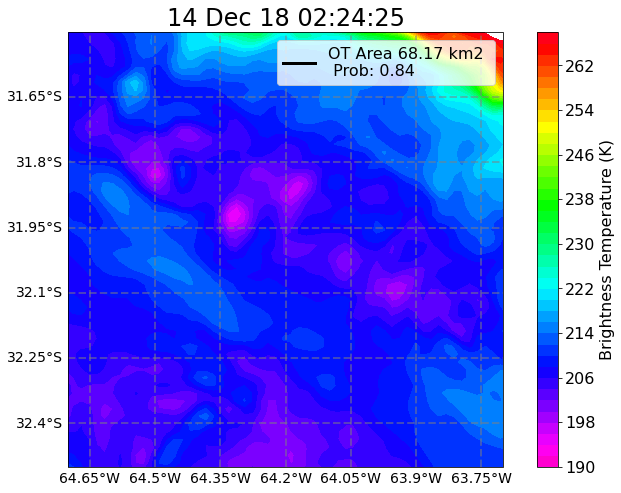

In [23]:
df_list = []
filtered_df_list = []

for file in files[12:25]:
    ds = xr.open_dataset(file).squeeze()
    df = process_ot_data(file, .7)
    
    df = df[df.lon > -64.5]
    
    ir_vals = ds.ir_brightness_temperature.values
    
    plt.figure(figsize=(12,8))
    
    lon = ds.longitude.values
    lat = ds.latitude.values

    ax = plt.subplot(111, projection=ccrs.PlateCarree())
    ax.set_extent((-64.7, -63.7, -32.5, -31.5))
    cf = plt.contourf(lon, lat, ir_vals, np.arange(190, 270, 2), cmap='gist_rainbow_r')
    cbar = plt.colorbar(cf)
    
    cbar.set_label('Brightness Temperature (K)', fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    
    try:
        df_ex = df[df.mintb == np.nanmin(df.mintb.values)]
        
    except:
        continue

    df_ex.plot(ax=ax, facecolor="none", edgecolor='black', lw=3,)

    ax.plot(0, 0, color='black', lw=3, label=f'OT Area {np.round(df_ex.area_polygon.values[0], 2)} km2 \n Prob: {np.round(df_ex.prob.values[0], 2)}')
    plt.legend(fontsize=16)

    #gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
    #                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    #try:
        #df_ex = df[df.mintb == np.nanmin(df.mintb.values)]
   #     df_ex = df[(df.lon > -64.5) & (df.lon < -64.2) & (df.lat > -32.1)]
    
        # If more than one OT, choose the one with the lowest min BT value
   #     df_ex = df_ex[df_ex.mintb == np.nanmin(df_ex.mintb.values)]

   #     df_ex.plot(ax=ax, facecolor="none", edgecolor='black', lw=3,)
   #     ax.plot(0, 0, color='black', lw=3, label=f'OT Area {np.round(df_ex.area_circle_polygon.values[0], 2)} km2 \n Prob: {np.round(df_ex.prob.values[0], 2)}')
   #     plt.legend(fontsize=16)
        
   #     filtered_df_list.append(df_ex)
        
    #except:
    #    None

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    
    gl.xlabel_style = {'size': 14, 'color': 'k'}
    gl.ylabel_style = {'size': 14, 'color': 'k'}

    plt.title(pd.to_datetime(df.time.values[0]).strftime('%d %b %y %H:%M:%S'), fontsize=24)
    plt.savefig(pd.to_datetime(df.time.values[0]).strftime('compare_plots/Dec14/%b_%d_%y_%H%M.%S.png'), dpi=300)
    plt.show()
    plt.close()
    
    df_list.append(df)

In [189]:
for df_sub in filtered_df_list[:15]:
    print(df_sub.time)

3   2018-12-14 02:12:25.000000512
Name: time, dtype: datetime64[ns]
3   2018-12-14 02:13:25.000000512
Name: time, dtype: datetime64[ns]
2   2018-12-14 02:14:25.000000512
Name: time, dtype: datetime64[ns]
2   2018-12-14 02:15:25.000000512
Name: time, dtype: datetime64[ns]
2   2018-12-14 02:16:25.000000512
Name: time, dtype: datetime64[ns]
3   2018-12-14 02:17:25.000000512
Name: time, dtype: datetime64[ns]
3   2018-12-14 02:18:25.000000512
Name: time, dtype: datetime64[ns]
4   2018-12-14 02:19:25.000000512
Name: time, dtype: datetime64[ns]
4   2018-12-14 02:20:25.000000512
Name: time, dtype: datetime64[ns]
4   2018-12-14 02:21:25.000000512
Name: time, dtype: datetime64[ns]
3   2018-12-14 02:22:25.000000512
Name: time, dtype: datetime64[ns]
4   2018-12-14 02:23:25.000000512
Name: time, dtype: datetime64[ns]
6   2018-12-14 02:24:25.000000512
Name: time, dtype: datetime64[ns]
6   2018-12-14 02:25:25.000000512
Name: time, dtype: datetime64[ns]
5   2018-12-14 02:26:25.000000512
Name: time, dt

In [348]:
len(filtered_df_list)

20

In [190]:
df = pd.concat(filtered_df_list[:15])

In [191]:
df = df[df.time != '2018-12-14 02:22:25.000000000'].reset_index()

In [192]:
df.index = df.time

<AxesSubplot:xlabel='time'>

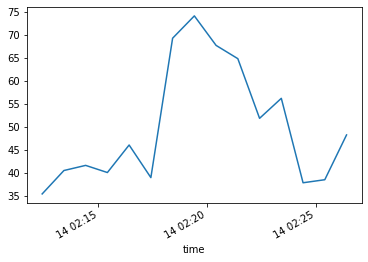

In [193]:
df.area_circle_polygon.plot()

<AxesSubplot:xlabel='time'>

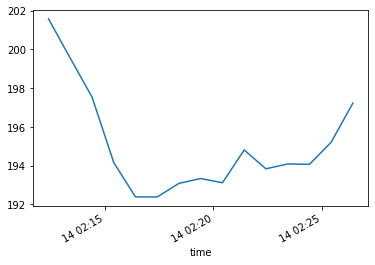

In [194]:
df.mintb.plot()

Text(0.5, 1.0, '14 December 2018 MCS OTA')

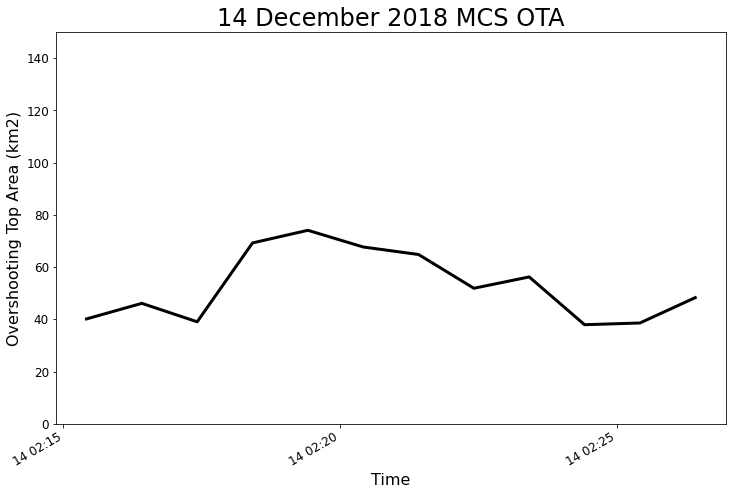

In [195]:
plt.figure(figsize=(12,8))
df[df.prob > .7].area_circle_polygon.plot(linewidth=3, color='black')
#df[df.prob > .7].area_circle_polygon[3:].plot(linewidth=3, color='black', label='2nd OT')
plt.ylim(0,150)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

ax.xaxis.set_minor_locator(AutoMinorLocator())

plt.ylabel('Overshooting Top Area (km2)', fontsize=16)
plt.xlabel('Time', fontsize=16)

#plt.legend(fontsize=16)

plt.title('14 December 2018 MCS OTA', fontsize=24)

In [196]:
trop_temp = df.tropopause_temperature.values.mean()

Text(0.5, 1.0, '14 December 2018 MCS \n OT Minimum Brightness Temperature')

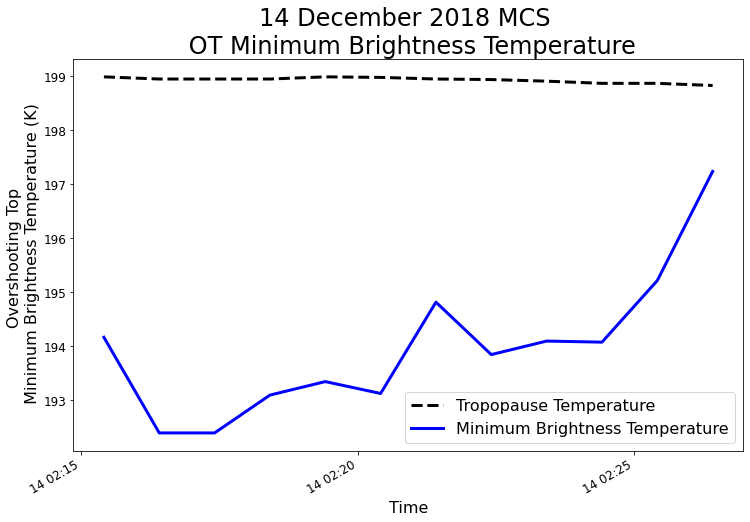

In [197]:
plt.figure(figsize=(12,8))
df[df.prob > .7].tropopause_temperature.plot(linewidth=3, linestyle='--', color='black', label='Tropopause Temperature')
df[df.prob > .7].mintb.plot(linewidth=3, color='blue', label='Minimum Brightness Temperature')
#df[df.prob > .7].mintb[:3].plot(linewidth=3, color='red', label='1st OT')
#df[df.prob > .7].mintb[3:].plot(linewidth=3, color='black', label='2nd OT')
#plt.ylim(0,150)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

ax.xaxis.set_minor_locator(AutoMinorLocator())

#plt.axhline(trop_temp, label=f'Tropopause Temperature: {np.round(trop_temp,2)} K', linewidth=3, color='black', linestyle='--')

plt.ylabel('Overshooting Top \n Minimum Brightness Temperature (K)', fontsize=16)
plt.xlabel('Time', fontsize=16)

plt.legend(fontsize=16, loc='lower right')

plt.title('14 December 2018 MCS \n OT Minimum Brightness Temperature', fontsize=24)

Text(0.5, 1.0, '14 December 2018 MCS \n OT Cloud Top Height')

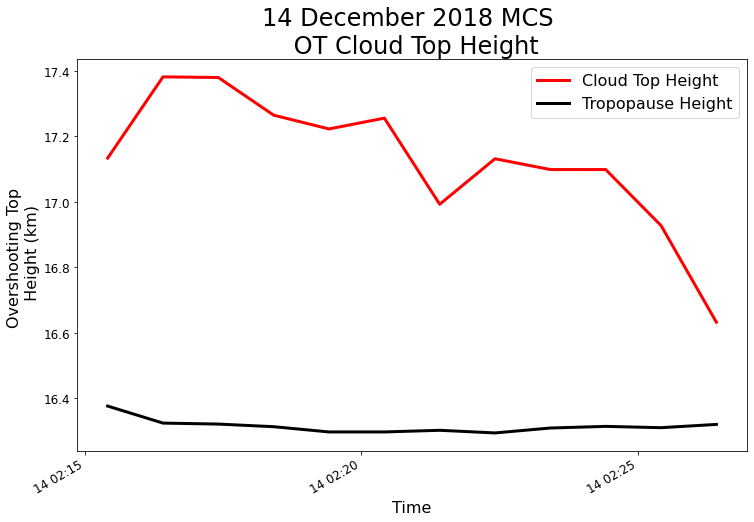

In [198]:
plt.figure(figsize=(12,8))
df[df.prob > .7].cloudtop_height.plot(linewidth=3, color='red', label='Cloud Top Height')
df[df.prob > .7].tropopause_height.plot(linewidth=3, color='black', label='Tropopause Height')
#plt.ylim(0,150)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

ax.xaxis.set_minor_locator(AutoMinorLocator())
#plt.axhline(trop_height, label=f'Tropopause Height: {np.round(trop_height,2)} km', linewidth=3, color='black', linestyle='--')

plt.ylabel('Overshooting Top \n Height (km)', fontsize=16)
plt.xlabel('Time', fontsize=16)

plt.legend(loc='upper right', fontsize=16)

plt.title('14 December 2018 MCS \n OT Cloud Top Height', fontsize=24)

In [199]:
df[df.prob > .7]

index  area_circle_mean  area_circle_median  \
time                                                                         
2018-12-14 02:15:25.000000512      2         45.161587           42.764609   
2018-12-14 02:16:25.000000512      2         52.460898           44.429360   
2018-12-14 02:17:25.000000512      3         43.147927           51.047807   
2018-12-14 02:18:25.000000512      3         75.347240           62.038170   
2018-12-14 02:19:25.000000512      4         83.139718           71.943845   
2018-12-14 02:20:25.000000512      4         73.823728           55.992223   
2018-12-14 02:21:25.000000512      4         72.997399           71.928863   
2018-12-14 02:22:25.000000512      3         58.082477           52.920342   
2018-12-14 02:23:25.000000512      4         62.704236           52.840929   
2018-12-14 02:24:25.000000512      6         42.713085           36.695613   
2018-12-14 02:25:25.000000512      6         43.132270           42.752282   
2018-12-14 02:26:25.000000512      5         54.653763           44.410219   

                               area_circle_polygon  cloudtop_height  e_radial  \
time                                                                            
2018-12-14 02:15:25.000000512            40.137743        17.133001       5.0   
2018-12-14 02:16:25.000000512            46.100451        17.381001       4.0   
2018-12-14 02:17:25.000000512            39.036624        17.379002       3.0   
2018-12-14 02:18:25.000000512            69.240941        17.264000       4.0   
2018-12-14 02:19:25.000000512            74.079337        17.222000       7.0   
2018-12-14 02:20:25.000000512            67.684649        17.255001       5.0   
2018-12-14 02:21:25.000000512            64.809910        16.992001       4.0   
2018-12-14 02:22:25.000000512            51.882368        17.131001       3.0   
2018-12-14 02:23:25.000000512            56.217753        17.098001       6.0   
2018-12-14 02:24:25.000000512            37.921218        17.098001       4.0   
2018-12-14 02:25:25.000000512            38.579593        16.927000       5.0   
2018-12-14 02:26:25.000000512            48.283925        16.632000       4.0   

                                                                   e_radial_del2  \
time                                                                               
2018-12-14 02:15:25.000000512  [0.232147216796875, 0.3162193298339844, 0.3344...   
2018-12-14 02:16:25.000000512  [0.2633514404296875, 0.3406410217285156, 0.304...   
2018-12-14 02:17:25.000000512  [0.230255126953125, 0.2561492919921875, 0.0994...   
2018-12-14 02:18:25.000000512  [0.32587432861328125, 0.4842567443847656, 0.55...   
2018-12-14 02:19:25.000000512  [0.187957763671875, 0.2776336669921875, 0.3737...   
2018-12-14 02:20:25.000000512  [0.294921875, 0.42510223388671875, 0.496726989...   
2018-12-14 02:21:25.000000512  [0.29632568359375, 0.42275238037109375, 0.4506...   
2018-12-14 02:22:25.000000512  [0.2072296142578125, 0.24999618530273438, 0.17...   
2018-12-14 02:23:25.000000512  [0.28281402587890625, 0.3996734619140625, 0.46...   
2018-12-14 02:24:25.000000512  [0.2642974853515625, 0.344482421875, 0.3178443...   
2018-12-14 02:25:25.000000512  [0.3408050537109375, 0.4969329833984375, 0.579...   
2018-12-14 02:26:25.000000512  [0.2240753173828125, 0.3194236755371094, 0.347...   

                                                                            e_tb  \
time                                                                               
2018-12-14 02:15:25.000000512  [197.88063049316406, 197.86566162109375, 198.3...   
2018-12-14 02:16:25.000000512  [196.16455078125, 196.80142211914062, 197.9649...   
2018-12-14 02:17:25.000000512  [196.31793212890625, 197.85450744628906, 199.8...   
2018-12-14 02:18:25.000000512  [195.41659545898438, 196.1536407470703, 197.54...   
2018-12-14 02:19:25.000000512  [195.19509887695312, 195.1221923828125, 195.42...   
2018-12-14 02:20:25.000000512  [195.96

In [200]:
df[df.prob > .7].to_csv('Revised_OTs_14_Dec_2018_0214_0225.csv')

In [308]:
df = pd.read_csv('Revised_OTs_14_Dec_2018_0212_0225.csv')